# Gesture Recognition

In [1]:
# Hardware Accelerator: NVIDIA A100 GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 25 12:02:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Importing the libraries
import os
import zipfile
import datetime
import random as rn

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
import cv2

from keras import backend as K
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D, ConvLSTM2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

In [3]:
# Set seed for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [4]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
zip_ref = zipfile.ZipFile('/content/drive/My Drive/Datasets/Gesture Recognition.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
zip_ref.close()

In [6]:
train_doc = np.random.permutation(open('/tmp/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/tmp/Project_data/val.csv').readlines())
batch_size = 300
seq_idx = [5, 6, 7, 8, 9, 10, 15, 17, 18, 20, 25, 26, 27, 28, 29] # More frames from beginning & end

# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size, is_aug = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx
    x, y, z = len(img_idx), 120, 120 # (x,y,z) is the final size of the input images
    while True:
        # doubling the data for augmentation
        if is_aug:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list) 

        batch_size = batch_size

        num_batches = len(t)//batch_size if len(t)%batch_size == 0 else (len(t)//batch_size) + 1

        for batch in range(num_batches): # Iterate over the number of batches
            # Adjusting batch size for the remaining data points which are left after full batches
            if (len(t) % batch_size != 0) and (batch == num_batches - 1):
                batch_size = len(t) % batch_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                aug_type = None
                if is_aug and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type for all images in this folder
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder & sort them
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Get the dimensions of the image
                    height, width, channels = image.shape

                    if width > height:
                        # Crop the image to bottom-middle
                        image = image[:, 20:140]
                    else:
                        # Resize the image
                        image = cv2.resize(image, (y, z))

                    # Augment data
                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement\n",
                            image = np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur\n",
                            image = np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing\n",
                            image = np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image\n",
                            image = np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement\n",
                            image = np.array(ImageEnhance.Brightness((Image.fromarray(image, 'RGB'))).enhance(1.5))
                    
                    # Normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [8]:
# Testing generator
sample_generator = generator('/tmp/Project_data/train', train_doc, batch_size, is_aug=True)
sample_batch_data, sample_batch_labels = next(sample_generator)
sample_batch_data.shape

Source path =  /tmp/Project_data/train ; batch size = 300


(300, 15, 120, 120, 3)

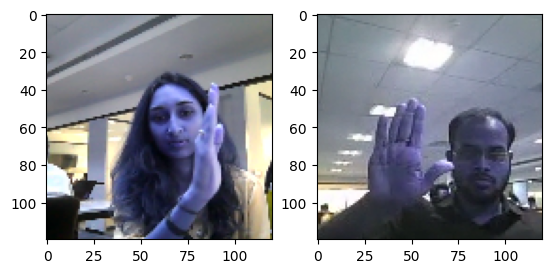

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_batch_data[15,3,:,:,:])   
ax[1].imshow(sample_batch_data[25,3,:,:,:])
plt.show()

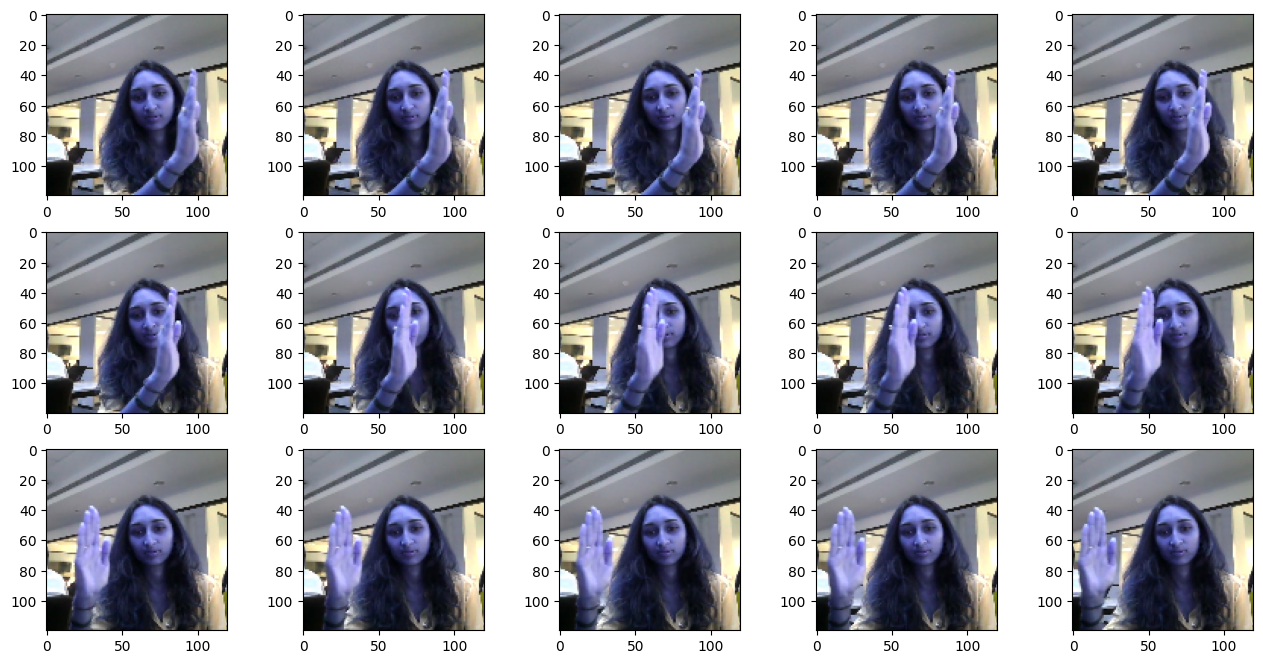

In [10]:
fig, ax = plt.subplots(3,5)
for i in range(len(seq_idx)):
  x = i//5
  y = i%5
  ax[x,y].imshow(sample_batch_data[15,i,:,:,:]) 
fig.set_size_inches(16, 8)
plt.show()

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/tmp/Project_data/train'
val_path = '/tmp/Project_data/val'
# num_train_sequences = len(train_doc) * 2 # Training gets augmentation
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 100


# Models

In [12]:
input_shape = (len(seq_idx), 120, 120, 3)
optimiser = optimizers.Adam(learning_rate=1e-4)

In [13]:
# train_generator = generator(train_path, train_doc, batch_size, is_aug=True)
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
def getCallbacks(model_name):
    filepath = '/tmp/models/' + model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/' + 'best_model.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0, verbose=1) # write the REducelronplateau code here

    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

    return [checkpoint, LR, earlystop]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
def plot_perf(history):
    plt.figure(figsize=(20,6))
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history['loss'])
    ax1 = plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history['categorical_accuracy'])
    ax2 = plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')

In [17]:
def fit_model(model, model_name):
    history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2,
                    callbacks=getCallbacks(model_name), validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None)
    plot_perf(history)

## Conv3D

In [19]:
model = Sequential()
model.add(Conv3D(8, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(16, kernel_size=3, activation='relu', padding="SAME"))
model.add(MaxPooling3D(pool_size=2, padding="SAME"))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 118, 118, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 59, 59, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 59, 59, 16)     3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 30, 30, 16)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 43200)             0         
                                                                 
 dense (Dense)               (None, 128)               5

Source path =  /tmp/Project_data/train ; batch size = 50
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 50

Epoch 1: val_loss improved from inf to 1.64298, saving model to /tmp/models/conv3D_1_2023-04-2418_32_03.657724/best_model.h5
14/14 - 33s - loss: 1.9492 - categorical_accuracy: 0.2398 - val_loss: 1.6430 - val_categorical_accuracy: 0.2900 - lr: 1.0000e-04 - 33s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.64298 to 1.52082, saving model to /tmp/models/conv3D_1_2023-04-2418_32_03.657724/best_model.h5
14/14 - 10s - loss: 1.5828 - categorical_accuracy: 0.2912 - val_loss: 1.5208 - val_categorical_accuracy: 0.3000 - lr: 1.0000e-04 - 10s/epoch - 744ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.52082
14/14 - 10s - loss: 1.5686 - categorical_accuracy: 0.2527 - val_loss: 1.5432 - val_categorical_accuracy: 0.4000 - lr: 1.0000e-04 - 10s/epoch - 750ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.52082 to 1.43800, saving model to /tmp/mod

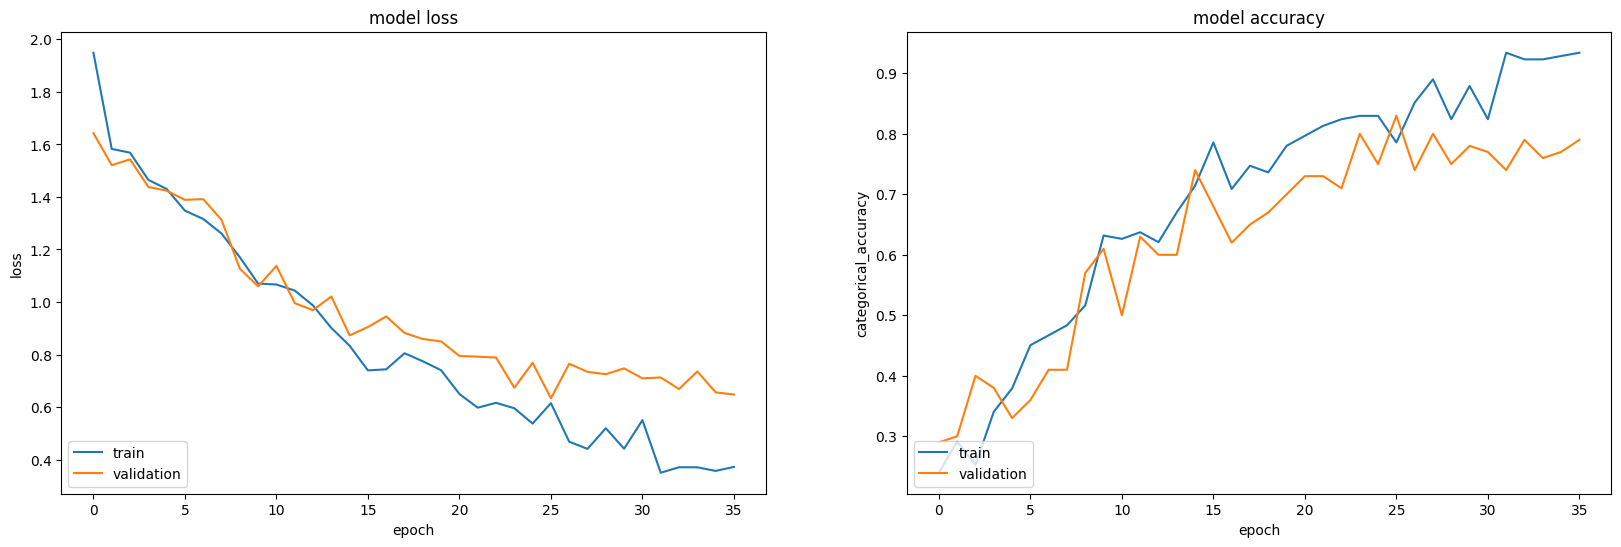

In [ ]:
# Without Augmentation
fit_model(model, 'conv3D_1')

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.78350, saving model to /tmp/models/conv3D_1_2023-04-2510_42_36.974721/best_model.h5
5/5 - 50s - loss: 1.9769 - categorical_accuracy: 0.2157 - val_loss: 1.7835 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 50s/epoch - 10s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.78350 to 1.55118, saving model to /tmp/models/conv3D_1_2023-04-2510_42_36.974721/best_model.h5
5/5 - 26s - loss: 1.7259 - categorical_accuracy: 0.2143 - val_loss: 1.5512 - val_categorical_accuracy: 0.3300 - lr: 1.0000e-04 - 26s/epoch - 5s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.55118
5/5 - 25s - loss: 1.6146 - categorical_accuracy: 0.1984 - val_loss: 1.6027 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-04 - 25s/epoch - 5s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.55118
5/5 - 17s - loss: 1.5892 - categorical

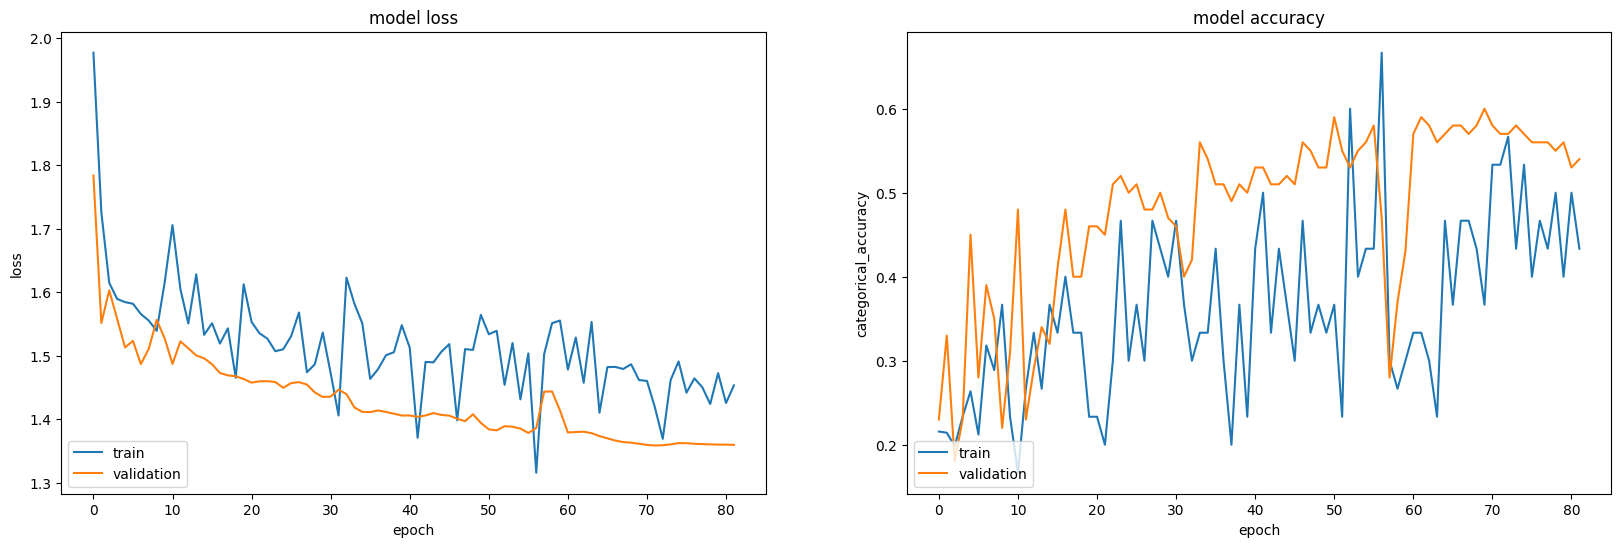

In [20]:
# With Augmentation
fit_model(model, 'conv3D_1')

## Conv3D with Batch Normalization

To solve overfitting

In [ ]:
model = Sequential()
model.add(Conv3D(8, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=2))


model.add(Conv3D(16, kernel_size=3, activation='relu', padding="SAME"))
model.add(MaxPooling3D(pool_size=2, padding="SAME"))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 13, 118, 118, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 13, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 59, 59, 8)     0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 59, 59, 16)     3472      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 30, 30, 16)    0         
 3D)                                                             
                                                      

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.56684, saving model to /tmp/models/conv3D_2_2023-04-2418_32_03.657724/best_model.h5
14/14 - 11s - loss: 1.8260 - categorical_accuracy: 0.2692 - val_loss: 1.5668 - val_categorical_accuracy: 0.2500 - lr: 4.0000e-06 - 11s/epoch - 813ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.56684
14/14 - 10s - loss: 1.4694 - categorical_accuracy: 0.3681 - val_loss: 1.5854 - val_categorical_accuracy: 0.2800 - lr: 4.0000e-06 - 10s/epoch - 721ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.56684 to 1.54177, saving model to /tmp/models/conv3D_2_2023-04-2418_32_03.657724/best_model.h5
14/14 - 11s - loss: 1.2679 - categorical_accuracy: 0.4945 - val_loss: 1.5418 - val_categorical_accuracy: 0.3500 - lr: 4.0000e-06 - 11s/epoch - 807ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.54177
14/14 - 11s - loss: 1.3457 - categorical_accuracy: 0.4396 - val_loss: 1.5440 - val_categorical_accuracy: 0.3100 - lr: 4.0000e-06 - 11s/epo

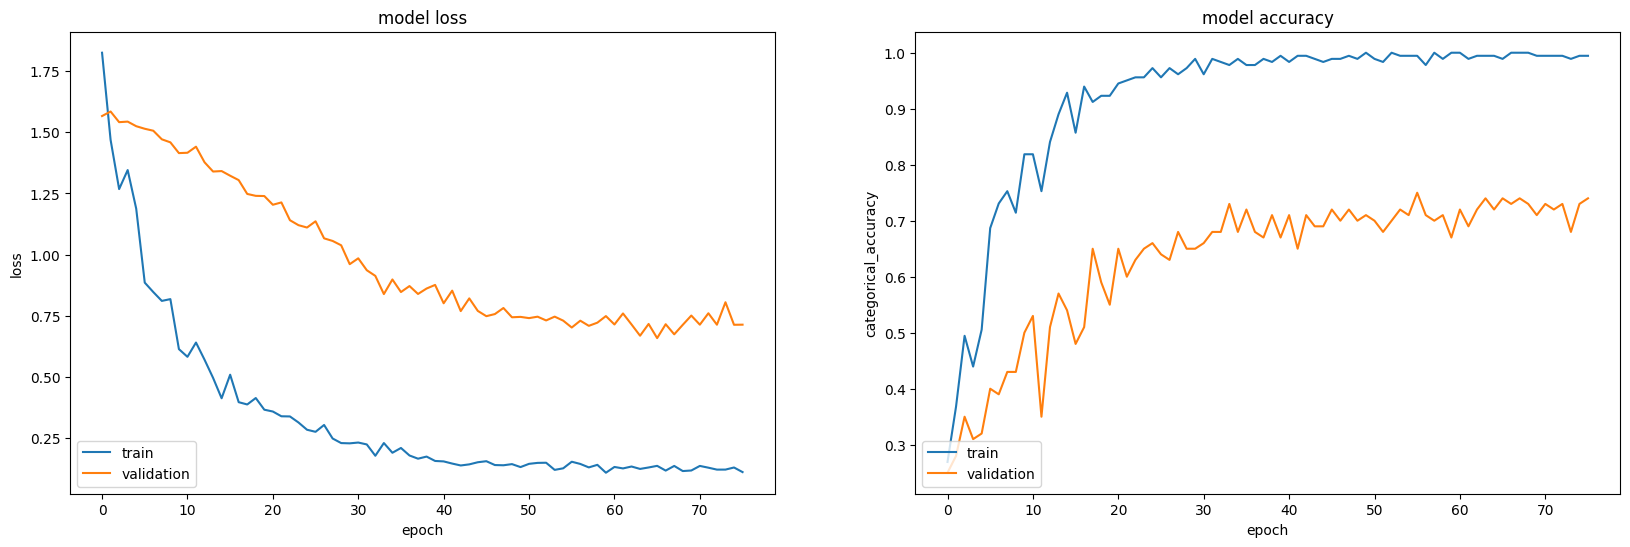

In [ ]:
fit_model(model, 'conv3D_2')

## Conv3D with Dropout Layers

In [ ]:
model = Sequential()
model.add(Conv3D(8, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(16, kernel_size=3, activation='relu', padding="SAME"))
model.add(MaxPooling3D(pool_size=2, padding="SAME"))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 13, 118, 118, 8)   656       
                                                                 
 batch_normalization_1 (Batc  (None, 13, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 59, 59, 8)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 6, 59, 59, 16)     3472      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 3, 30, 30, 16)    0         
 3D)                                                             
                                                      

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.61715, saving model to /tmp/models/conv3D_3_2023-04-2418_32_03.657724/best_model.h5
14/14 - 11s - loss: 1.7961 - categorical_accuracy: 0.2088 - val_loss: 1.6172 - val_categorical_accuracy: 0.1900 - lr: 6.4000e-09 - 11s/epoch - 815ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.61715 to 1.61638, saving model to /tmp/models/conv3D_3_2023-04-2418_32_03.657724/best_model.h5
14/14 - 11s - loss: 1.8067 - categorical_accuracy: 0.1593 - val_loss: 1.6164 - val_categorical_accuracy: 0.1800 - lr: 6.4000e-09 - 11s/epoch - 762ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.61638
14/14 - 11s - loss: 1.8138 - categorical_accuracy: 0.1923 - val_loss: 1.6180 - val_categorical_accuracy: 0.1600 - lr: 6.4000e-09 - 11s/epoch - 752ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.61638
14/14 - 11s - loss: 1.8106 - categorical_accuracy: 0.1923 - val_loss: 1.6186 - val_categorical_accuracy: 0.1700 - lr: 6.4000e-09 - 11s/epo

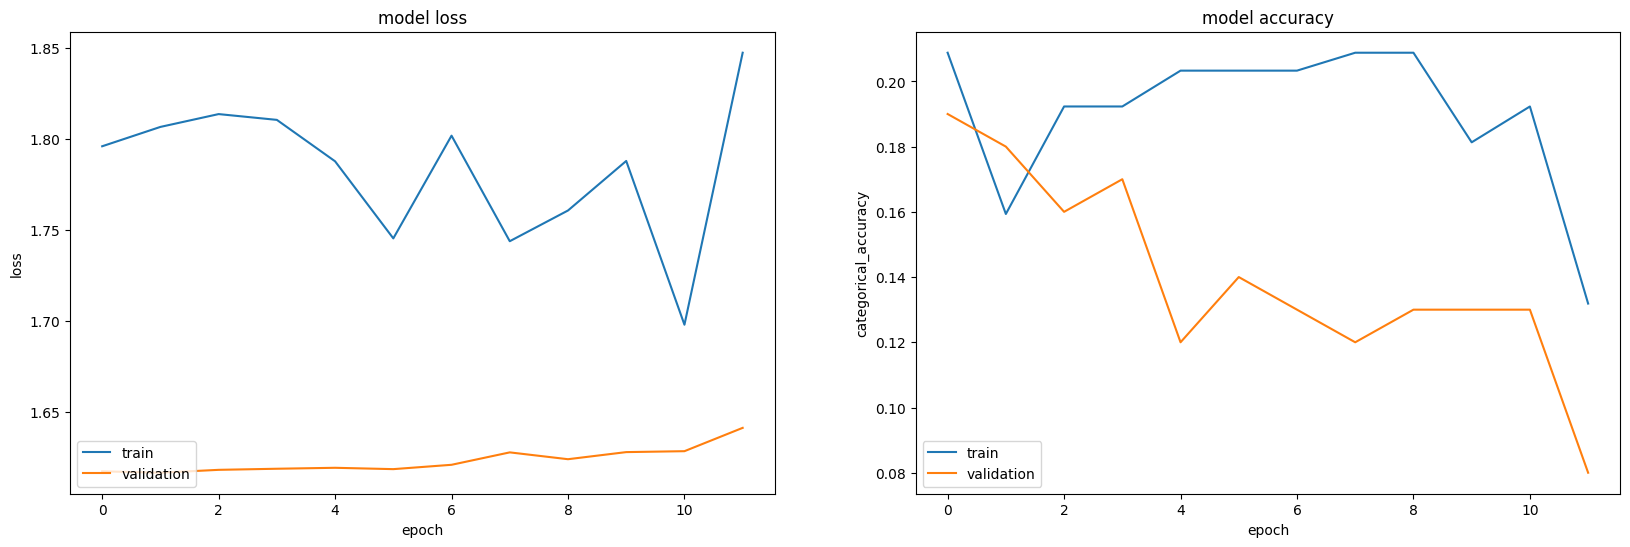

In [ ]:
fit_model(model, 'conv3D_3')

## More Complex Conv3D

In [21]:
model = Sequential()

model.add(Conv3D(8, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(8, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, kernel_size=3, activation='relu'))
model.add(Conv3D(16, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(64, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(64, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 13, 118, 118, 8)   656       
                                                                 
 conv3d_3 (Conv3D)           (None, 11, 116, 116, 8)   1736      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 5, 58, 58, 8)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 56, 56, 16)     3472      
                                                                 
 conv3d_5 (Conv3D)           (None, 1, 54, 54, 16)     6928      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 1, 27, 27, 16)    0         
 3D)                                                  

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.61005, saving model to /tmp/models/conv3D_4_2023-04-2510_42_36.974721/best_model.h5
5/5 - 9s - loss: 1.6116 - categorical_accuracy: 0.1667 - val_loss: 1.6101 - val_categorical_accuracy: 0.2200 - lr: 1.6000e-07 - 9s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.61005
5/5 - 8s - loss: 1.6128 - categorical_accuracy: 0.0667 - val_loss: 1.6101 - val_categorical_accuracy: 0.2200 - lr: 1.6000e-07 - 8s/epoch - 2s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.61005
5/5 - 8s - loss: 1.6116 - categorical_accuracy: 0.1667 - val_loss: 1.6101 - val_categorical_accuracy: 0.2200 - lr: 1.6000e-07 - 8s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.61005
5/5 - 8s - loss: 1.6074 - categorical_accuracy: 0.3000 - val_loss: 1.6101 - val_categorical_accuracy: 0.2200 - lr: 1.6000e-07 - 8s/epoch - 2s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.61005
5/5 - 8s - loss: 1.6093 - categori

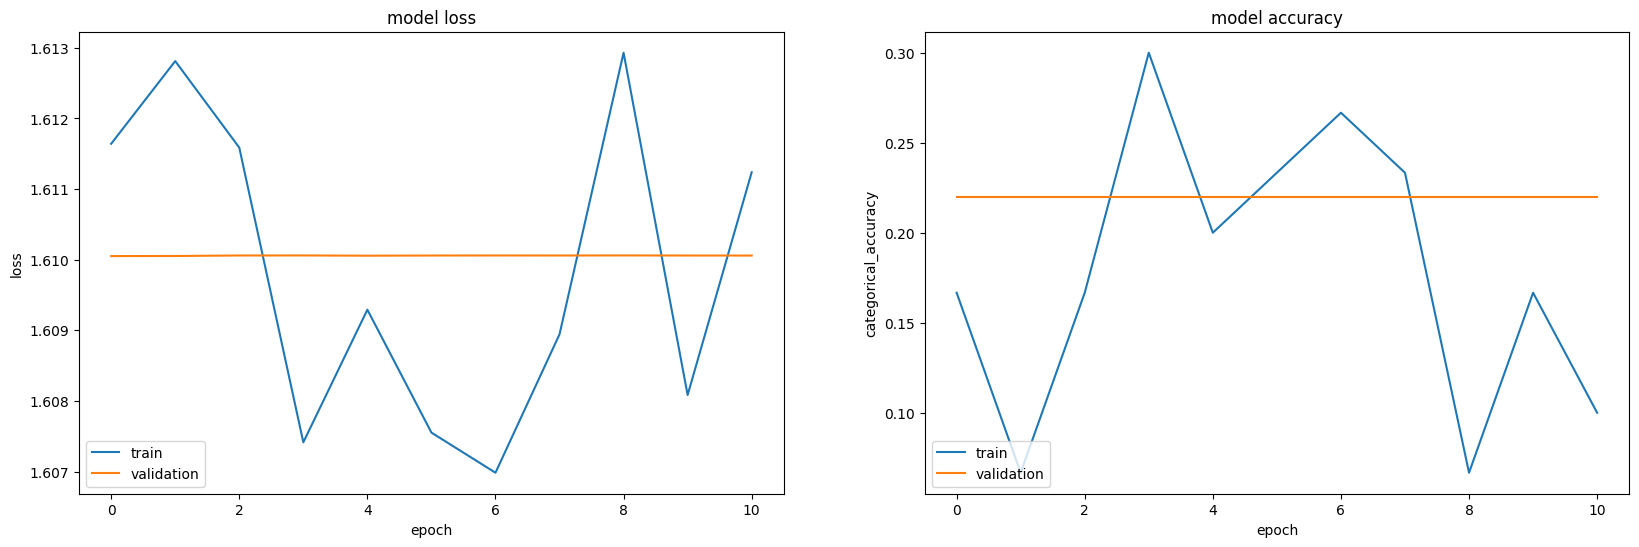

In [22]:
# With Augmentation
fit_model(model, 'conv3D_4')

## TimeDistributed Conv2D

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 15, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_12 (Bat  (None, 15, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_32 (TimeDi  (None, 15, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 15, 28, 28, 64)  

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.61037, saving model to /tmp/models/TimeDistributed_2023-04-2419_37_31.525209/best_model.h5
27/27 - 17s - loss: 2.1646 - categorical_accuracy: 0.2336 - val_loss: 1.6104 - val_categorical_accuracy: 0.2100 - lr: 1.0240e-11 - 17s/epoch - 623ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.61037
27/27 - 15s - loss: 2.0777 - categorical_accuracy: 0.2051 - val_loss: 1.6340 - val_categorical_accuracy: 0.2000 - lr: 1.0240e-11 - 15s/epoch - 538ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.61037
27/27 - 15s - loss: 2.1538 - categorical_accuracy: 0.2165 - val_loss: 1.6748 - val_categorical_accuracy: 0.1500 - lr: 1.0240e-11 - 15s/epoch - 569ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.61037
27/27 - 15s - loss: 2.1628 - categorical_accuracy: 0.2222 - val_loss: 1.6812 - val_categorical_accuracy: 0.2200 - lr: 1.0240e-11 - 15s/epoch - 539ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.61037

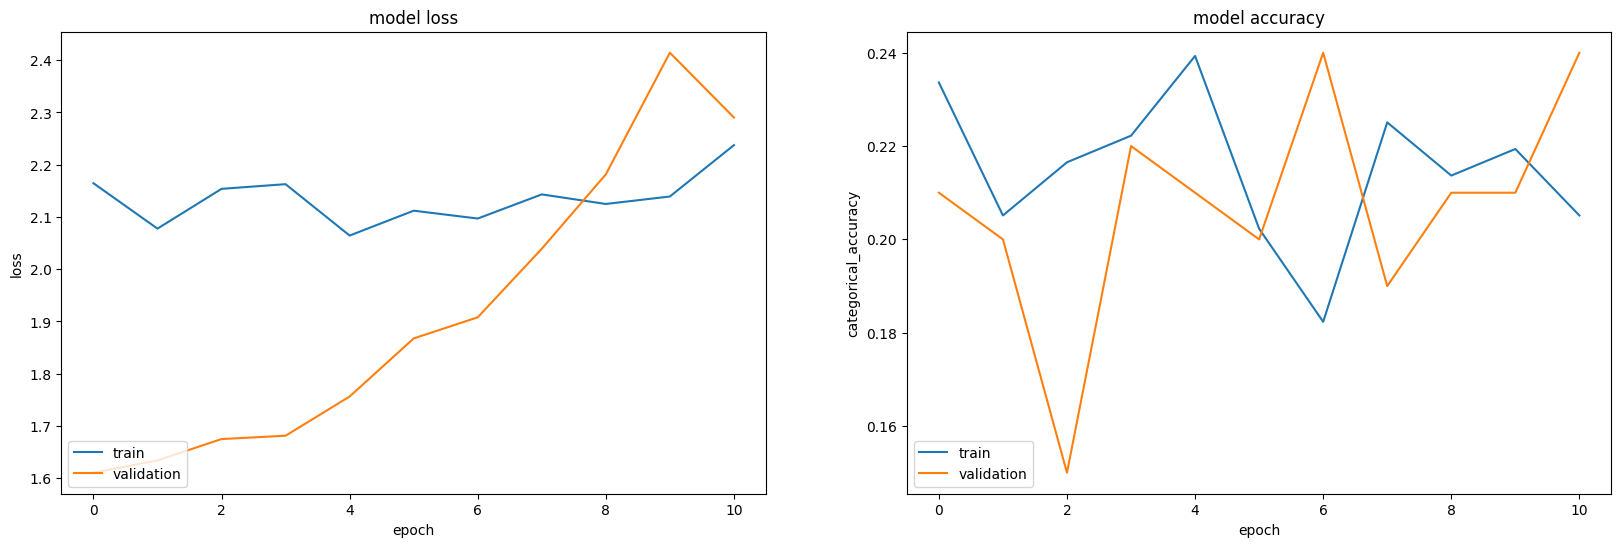

In [ ]:
fit_model(model, 'TimeDistributed')

## TimeDistributed Conv2D + ConvLSTM2D

In [23]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 15, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 116, 116, 8)       4640      
                                                                 
 batch_normalization_1 (Batc  (None, 116, 116, 8)      32        
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 8)                0         
 lobalAveragePooling2D)                               

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.60805, saving model to /tmp/models/conv_lstm_2d_2023-04-2510_42_36.974721/best_model.h5
5/5 - 12s - loss: 1.6354 - categorical_accuracy: 0.0667 - val_loss: 1.6081 - val_categorical_accuracy: 0.2200 - lr: 6.4000e-09 - 12s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.60805 to 1.60801, saving model to /tmp/models/conv_lstm_2d_2023-04-2510_42_36.974721/best_model.h5
5/5 - 8s - loss: 1.6245 - categorical_accuracy: 0.2000 - val_loss: 1.6080 - val_categorical_accuracy: 0.2200 - lr: 6.4000e-09 - 8s/epoch - 2s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.60801 to 1.60796, saving model to /tmp/models/conv_lstm_2d_2023-04-2510_42_36.974721/best_model.h5
5/5 - 8s - loss: 1.6184 - categorical_accuracy: 0.1667 - val_loss: 1.6080 - val_categorical_accuracy: 0.2200 - lr: 6.4000e-09 - 8s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.60796 to 1.60791, saving model to /tmp/models/conv_lstm_2d_2023-04-2510_42_3

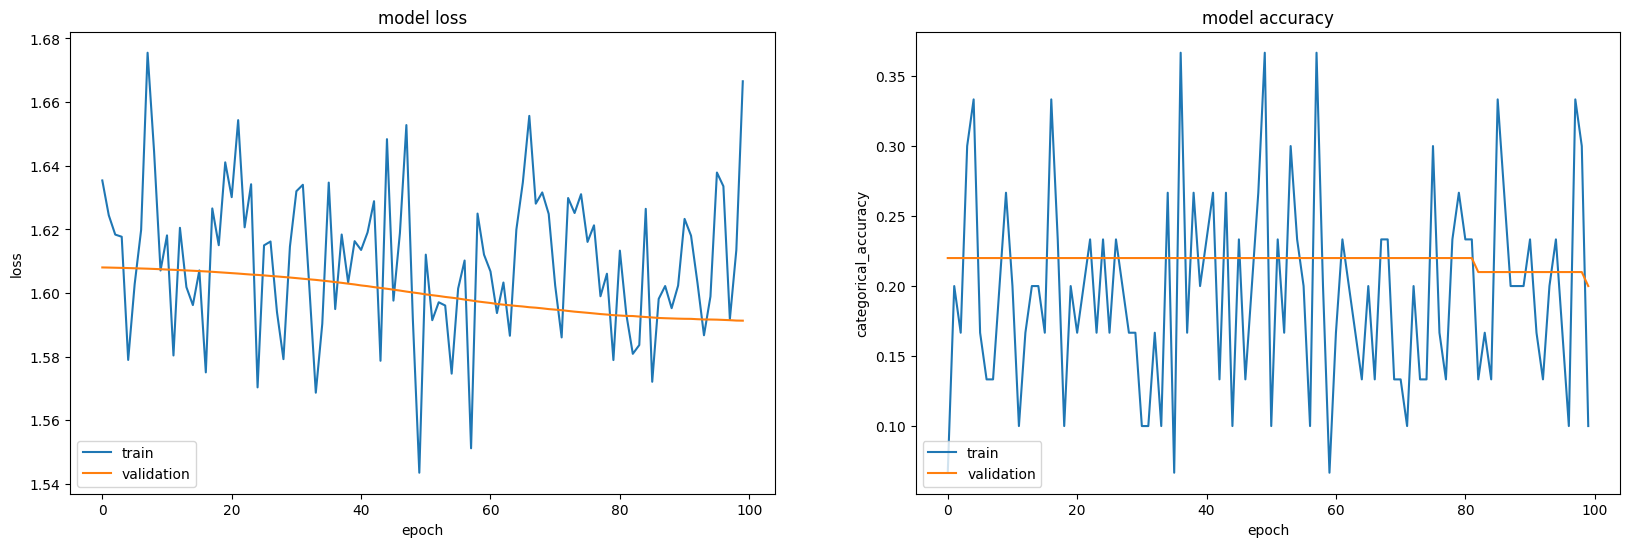

In [24]:
# With Augmentation
fit_model(model, 'conv_lstm_2d')

## More complex TimeDistributed Conv2D + ConvLSTM2D

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model.add(
    ConvLSTM2D(16, kernel_size = 3, return_sequences=False)
)
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(TimeDistributed(
    Dense(128, activation='relu'))
)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 118, 118, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 116, 116, 32)  4640     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 114, 114, 64)  18496    
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 112, 112, 128  73856    
 tributed)                   )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 110, 110, 16)      8

Source path =  /tmp/Project_data/train ; batch size = 25
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 25

Epoch 1: val_loss improved from inf to 1.60477, saving model to /tmp/models/ConvLSTM2D_2023-04-2419_37_31.525209/best_model.h5
27/27 - 41s - loss: 1.6090 - categorical_accuracy: 0.1946 - val_loss: 1.6048 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 41s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.60477 to 1.59582, saving model to /tmp/models/ConvLSTM2D_2023-04-2419_37_31.525209/best_model.h5
27/27 - 15s - loss: 1.6070 - categorical_accuracy: 0.2080 - val_loss: 1.5958 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-04 - 15s/epoch - 567ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.59582
27/27 - 15s - loss: 1.6027 - categorical_accuracy: 0.2051 - val_loss: 1.6030 - val_categorical_accuracy: 0.1400 - lr: 1.0000e-04 - 15s/epoch - 568ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.59582
27/27 - 15s - loss: 1.603

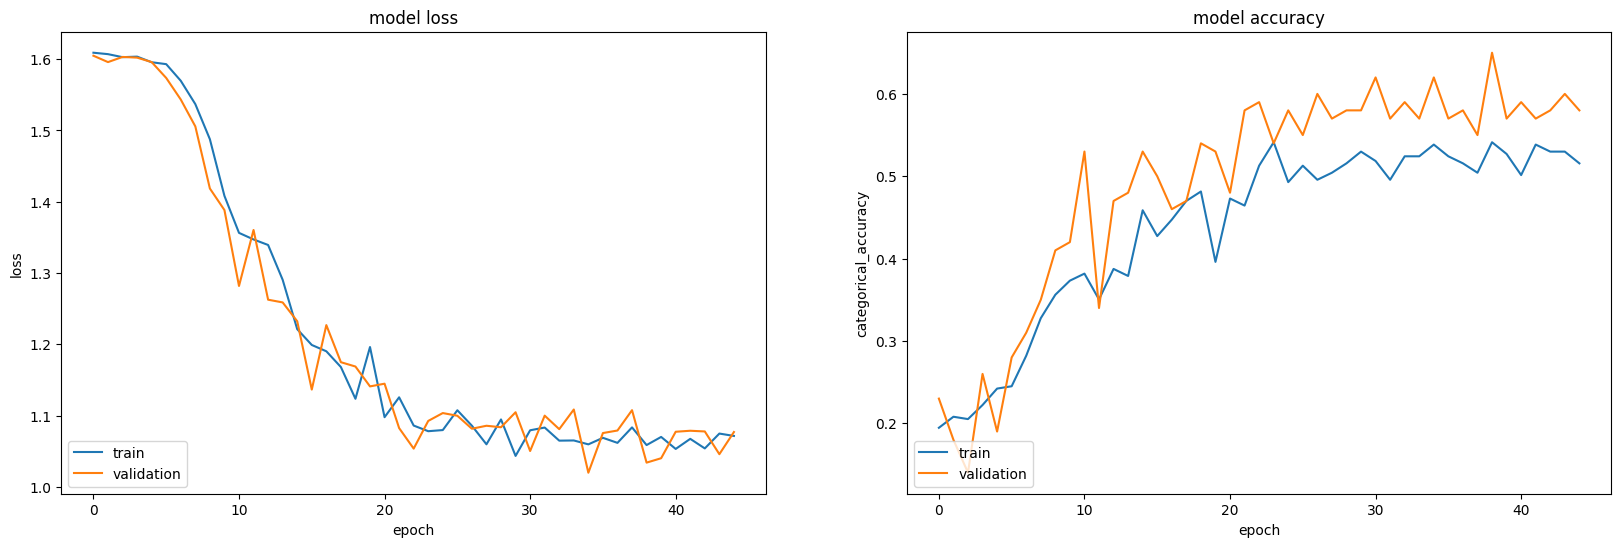

In [ ]:
fit_model(model, 'ConvLSTM2D')

## TimeDistributed Conv2D + GRU

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)

model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 15, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 59, 59, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 57, 57, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 28, 28, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 16)          

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.61850, saving model to /tmp/models/GRU1_2023-04-2419_37_31.525209/best_model.h5
27/27 - 19s - loss: 2.8672 - categorical_accuracy: 0.0969 - val_loss: 1.6185 - val_categorical_accuracy: 0.2200 - lr: 1.6000e-07 - 19s/epoch - 702ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.61850
27/27 - 15s - loss: 2.8392 - categorical_accuracy: 0.1140 - val_loss: 1.6206 - val_categorical_accuracy: 0.2400 - lr: 1.6000e-07 - 15s/epoch - 554ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.61850
27/27 - 15s - loss: 2.8136 - categorical_accuracy: 0.0826 - val_loss: 1.6307 - val_categorical_accuracy: 0.1600 - lr: 1.6000e-07 - 15s/epoch - 560ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.61850
27/27 - 15s - loss: 2.8193 - categorical_accuracy: 0.0940 - val_loss: 1.6295 - val_categorical_accuracy: 0.1800 - lr: 1.6000e-07 - 15s/epoch - 564ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.61850
27/27 - 15

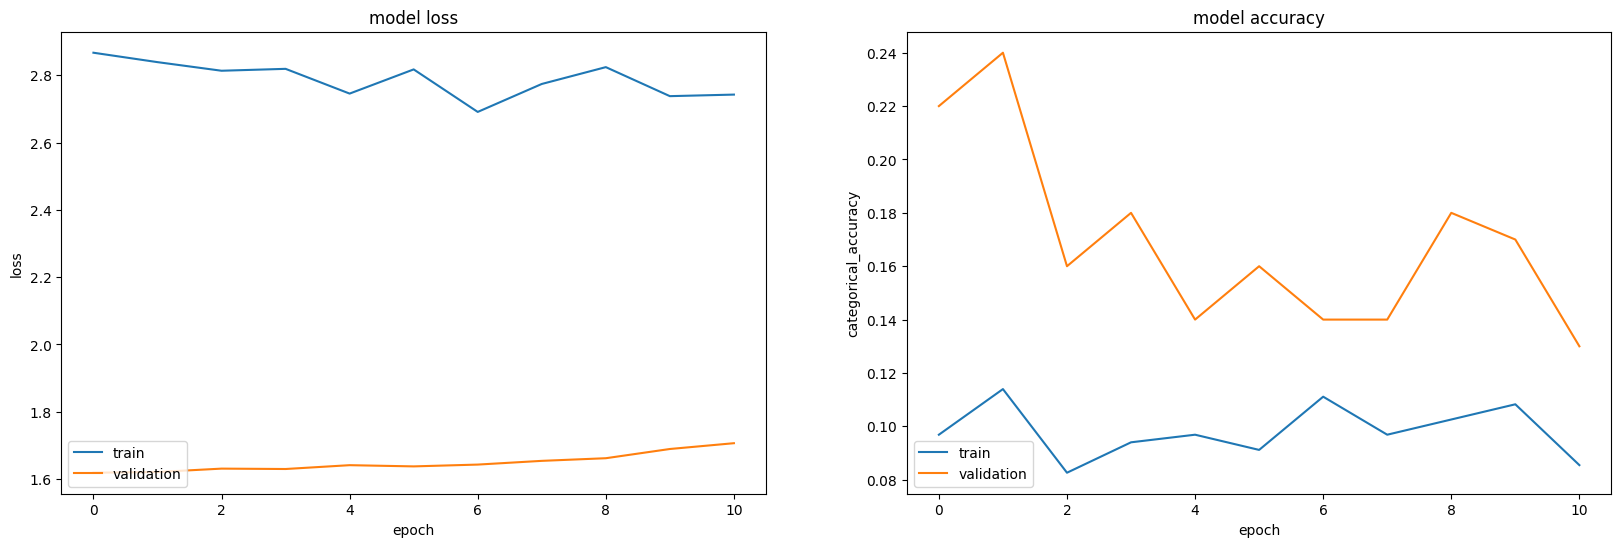

In [ ]:
fit_model(model, 'GRU1')

## TimeDistributed Conv2D + More GRU units

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)

model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(256))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 15, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 59, 59, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 57, 57, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 15, 28, 28, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 16)          

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.60856, saving model to /tmp/models/GRU2_2023-04-2419_37_31.525209/best_model.h5
27/27 - 18s - loss: 1.7670 - categorical_accuracy: 0.2336 - val_loss: 1.6086 - val_categorical_accuracy: 0.2300 - lr: 6.4000e-09 - 18s/epoch - 664ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.60856 to 1.60773, saving model to /tmp/models/GRU2_2023-04-2419_37_31.525209/best_model.h5
27/27 - 15s - loss: 1.7774 - categorical_accuracy: 0.2194 - val_loss: 1.6077 - val_categorical_accuracy: 0.2500 - lr: 6.4000e-09 - 15s/epoch - 564ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.60773
27/27 - 15s - loss: 1.8099 - categorical_accuracy: 0.2165 - val_loss: 1.6092 - val_categorical_accuracy: 0.1900 - lr: 6.4000e-09 - 15s/epoch - 558ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.60773 to 1.60695, saving model to /tmp/models/GRU2_2023-04-2419_37_31.525209/best_model.h5
27/27 - 15s - loss: 1.6824 - categorical_accuracy: 0.2792 - val_loss

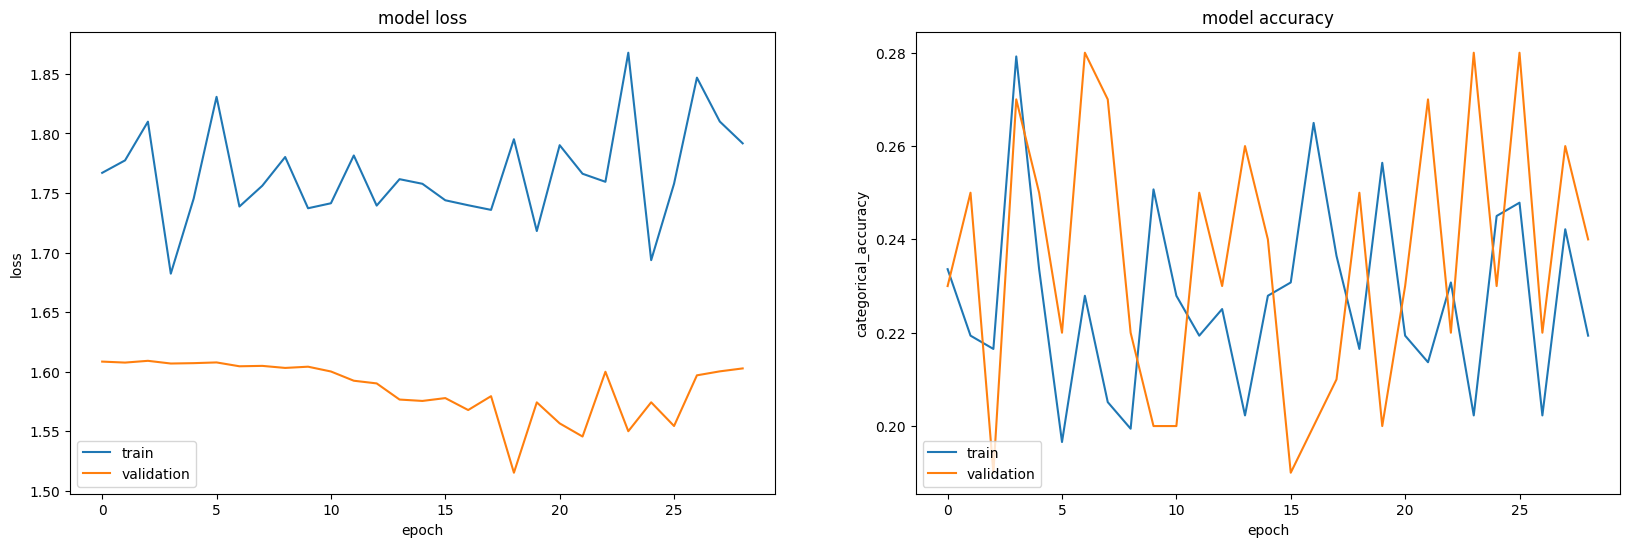

In [ ]:
fit_model(model, 'GRU2')

## TimeDistributed Conv2D + Even More GRU Units

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)

model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(2048))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 5, 118, 118, 8)   224       
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 5, 59, 59, 8)     0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 5, 57, 57, 16)    1168      
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 5, 28, 28, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 5, 16)           

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.60977, saving model to /tmp/models/GRU2048_2023-04-2116_27_22.217255/best_model.h5
4/4 - 7s - loss: 1.9010 - categorical_accuracy: 0.2083 - val_loss: 1.6098 - val_categorical_accuracy: 0.2100 - lr: 1.6384e-14 - 7s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss improved from 1.60977 to 1.60976, saving model to /tmp/models/GRU2048_2023-04-2116_27_22.217255/best_model.h5
4/4 - 3s - loss: 1.8732 - categorical_accuracy: 0.1667 - val_loss: 1.6098 - val_categorical_accuracy: 0.2100 - lr: 1.6384e-14 - 3s/epoch - 791ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.60976 to 1.60974, saving model to /tmp/models/GRU2048_2023-04-2116_27_22.217255/best_model.h5
4/4 - 3s - loss: 1.9834 - categorical_accuracy: 0.2917 - val_loss: 1.6097 - val_categorical_accuracy: 0.2200 - lr: 1.6384e-14 - 3s/epoch - 783ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.60974
4/4 - 3s - loss: 1.7605 - categorical_accuracy: 0.3333 - val_loss: 1.6098 - va

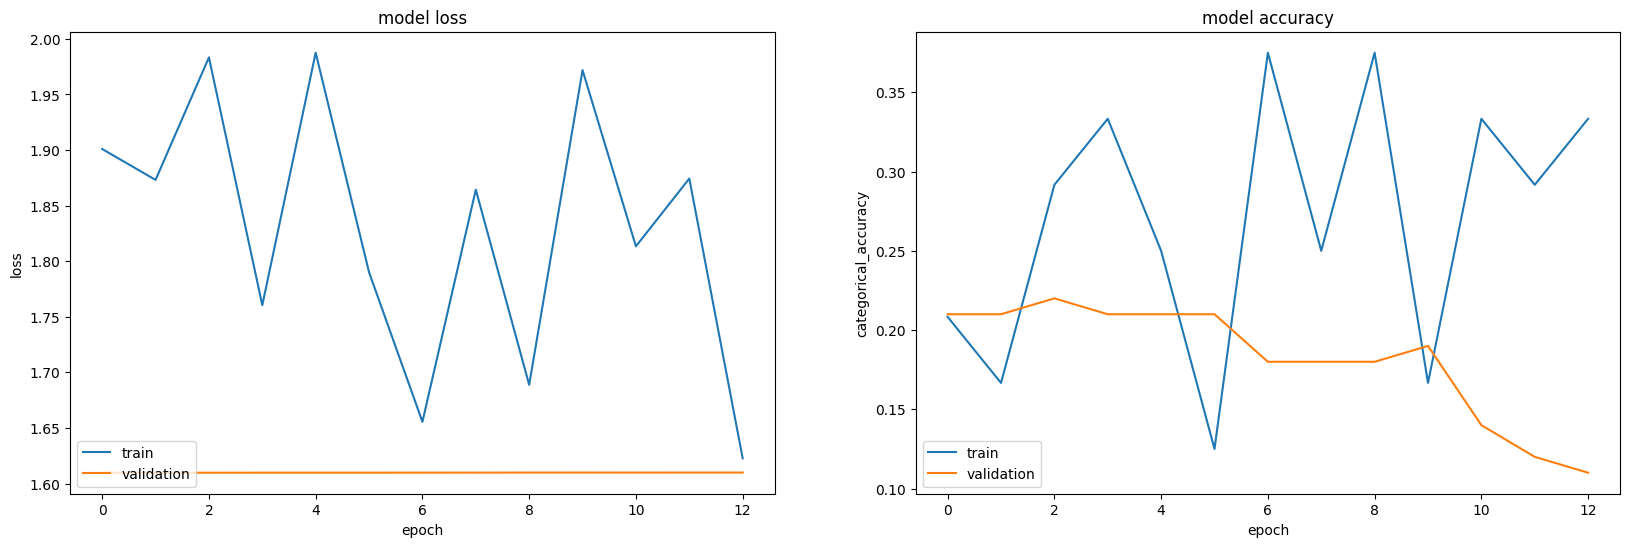

In [ ]:
fit_model(model, 'GRU2048')

## More Complex TimeDistributed Conv2D + GRU

In [ ]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimiser
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 15, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_8 (Batc  (None, 15, 59, 59, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 15, 59, 59, 32)    0         
                                                                 
 time_distributed_26 (TimeDi  (None, 15, 57, 57, 64)   18496     
 stributed)                                           

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.60777, saving model to /tmp/models/GRU3_2023-04-2419_37_31.525209/best_model.h5
27/27 - 19s - loss: 1.8589 - categorical_accuracy: 0.2621 - val_loss: 1.6078 - val_categorical_accuracy: 0.1700 - lr: 2.5600e-10 - 19s/epoch - 690ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.60777
27/27 - 15s - loss: 1.7934 - categorical_accuracy: 0.2507 - val_loss: 1.6080 - val_categorical_accuracy: 0.2800 - lr: 2.5600e-10 - 15s/epoch - 558ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.60777
27/27 - 15s - loss: 1.8079 - categorical_accuracy: 0.2735 - val_loss: 1.6277 - val_categorical_accuracy: 0.2100 - lr: 2.5600e-10 - 15s/epoch - 545ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.60777
27/27 - 15s - loss: 1.7452 - categorical_accuracy: 0.2707 - val_loss: 1.6470 - val_categorical_accuracy: 0.2100 - lr: 2.5600e-10 - 15s/epoch - 542ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.60777
27/27 - 15

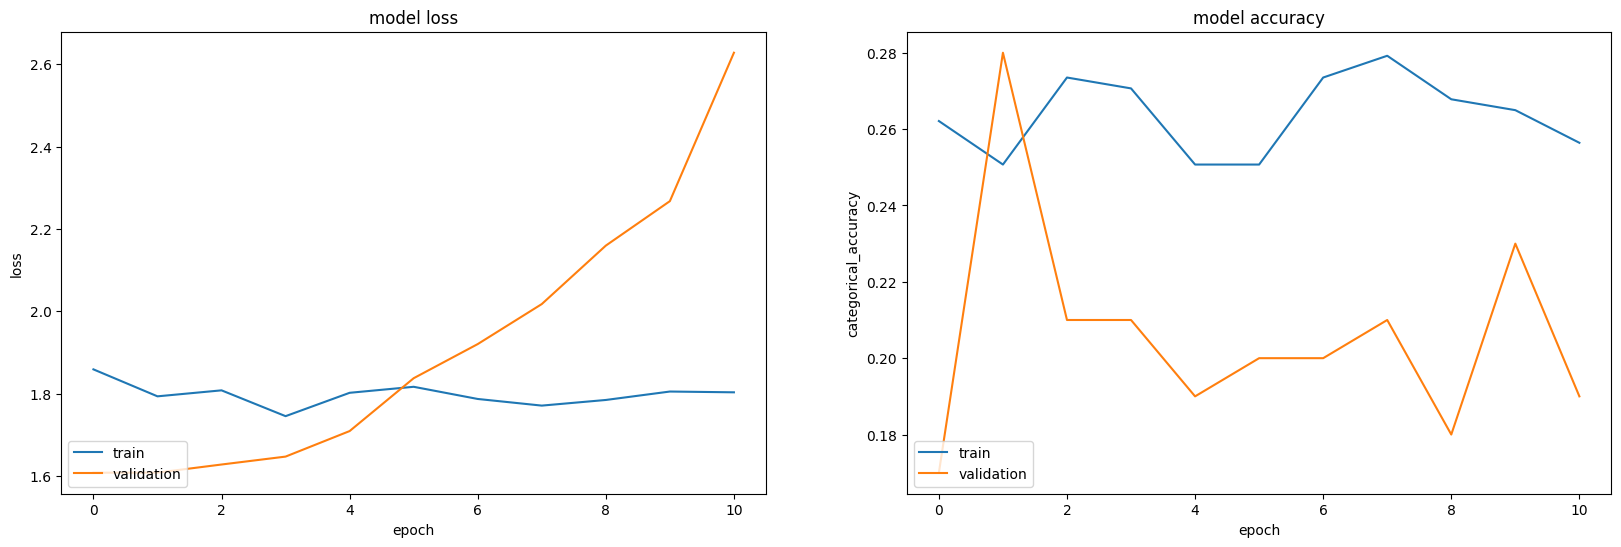

In [ ]:
fit_model(model, 'GRU3')

## ResNet50 (No Trainable Layer) + LSTM

In [ ]:
# # Load pre-trained ResNet50 model without the top layers
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model to non-trainable
# base_model.trainable = False

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an LSTM layer for sequence learning
# x = LSTM(128)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_lstm = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                             

Source path =  /tmp/Project_data/train ; batch size = 150
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 150

Epoch 1: val_loss improved from inf to 1.63989, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 37s - loss: 1.6850 - categorical_accuracy: 0.1900 - val_loss: 1.6399 - val_categorical_accuracy: 0.2400 - lr: 1.0000e-04 - 37s/epoch - 7s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.63989 to 1.60824, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 15s - loss: 1.6262 - categorical_accuracy: 0.2222 - val_loss: 1.6082 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 15s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.60824 to 1.60342, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 15s - loss: 1.6138 - categorical_accuracy: 0.1873 - val_loss: 1.6034 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04 - 15s/epoch - 3s/step
Ep

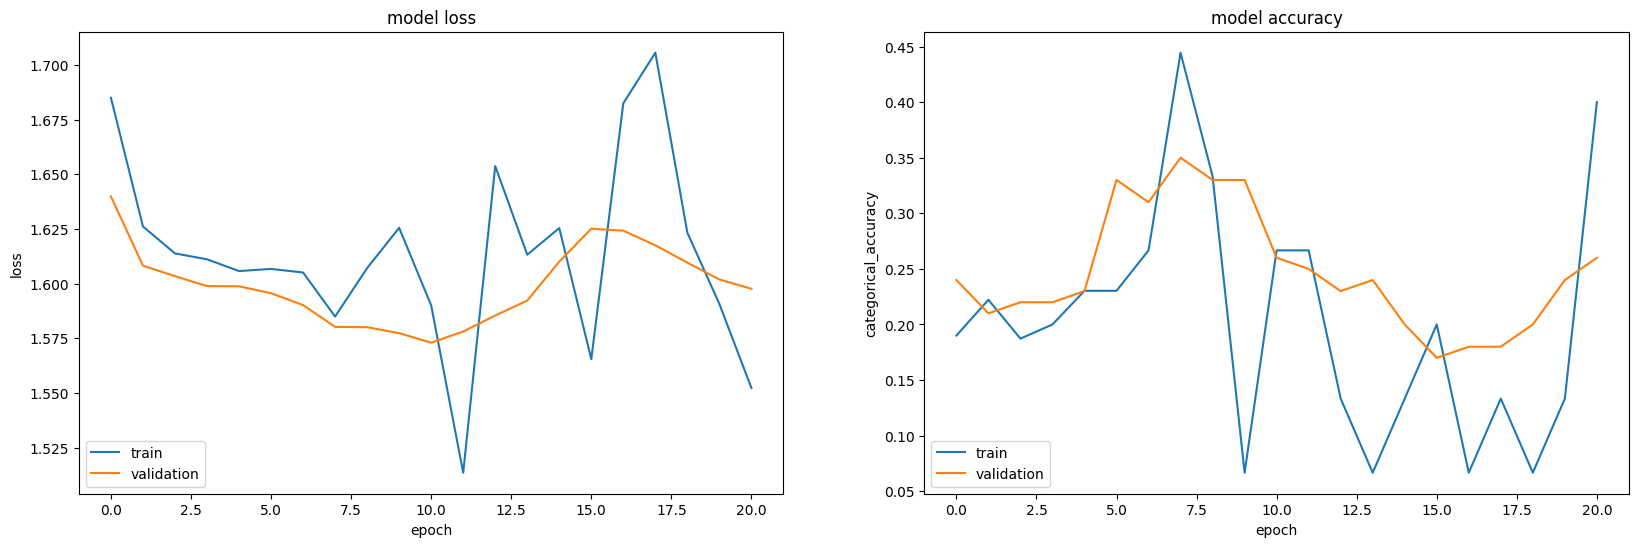

In [ ]:
# fit_model(model_resnet_lstm, 'resnet50_lstm')

## ResNet50 (No Trainable Layers) + More LSTM Units

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x2 = TimeDistributed(base_model)(inputs)
# x2 = TimeDistributed(GlobalAveragePooling2D())(x2)

# # Add an LSTM layer for sequence learning
# x2 = LSTM(256)(x2)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x2)

# # Compile the model
# model_resnet_lstm = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 256)               2360320   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                           

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.64760, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 16s - loss: 1.6878 - categorical_accuracy: 0.2000 - val_loss: 1.6476 - val_categorical_accuracy: 0.2300 - lr: 4.0000e-06 - 16s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.64760 to 1.64345, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 8s - loss: 1.9688 - categorical_accuracy: 0.0000e+00 - val_loss: 1.6435 - val_categorical_accuracy: 0.2300 - lr: 4.0000e-06 - 8s/epoch - 2s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.64345 to 1.63843, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 8s - loss: 1.6136 - categorical_accuracy: 0.1333 - val_loss: 1.6384 - val_categorical_accuracy: 0.2300 - lr: 4.0000e-06 - 8s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.63843 to 1.63402, saving model to /tmp/models/resnet50_lstm_2023-04-2

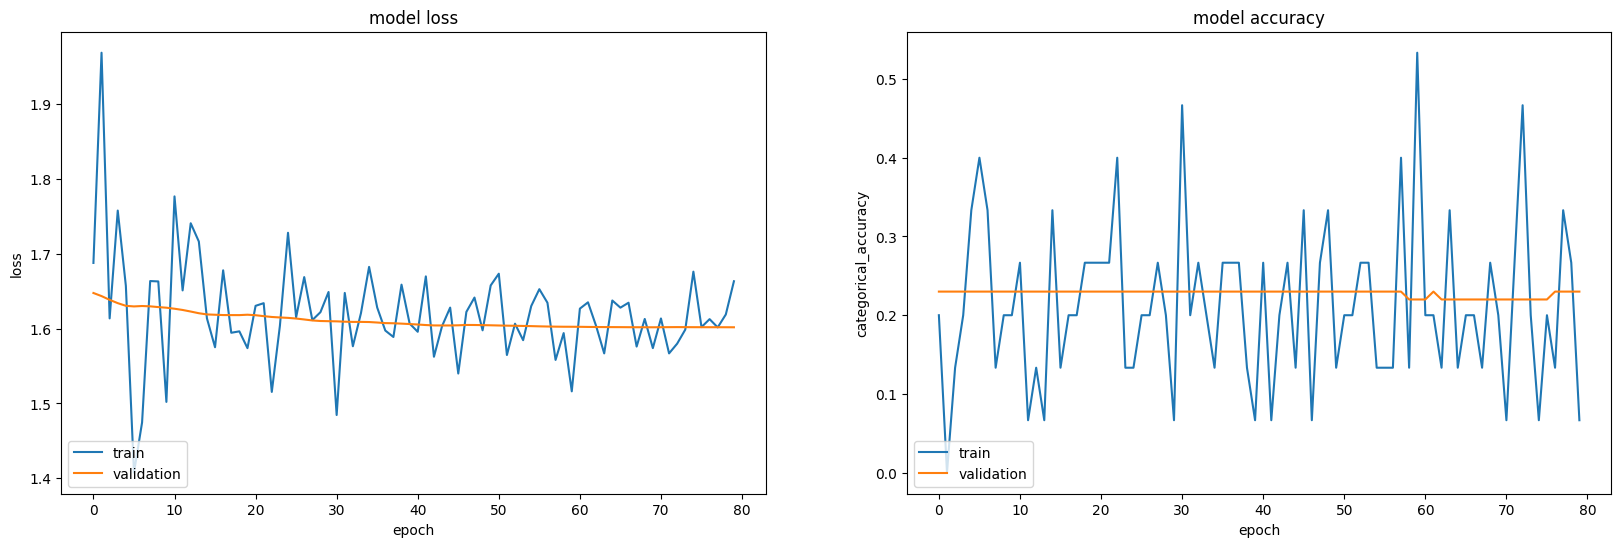

In [ ]:
# fit_model(model_resnet_lstm, 'resnet50_lstm')

## ResNet50 (No Trainable Layers) + Even More LSTM Units

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x3 = TimeDistributed(base_model)(inputs)
# x3 = TimeDistributed(GlobalAveragePooling2D())(x3)

# # Add an LSTM layer for sequence learning
# x3 = LSTM(1024)(x3)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x3)

# # Compile the model
# model_resnet_lstm = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 1024)              12587008  
                                                                 
 dense_2 (Dense)             (None, 5)                 5125      
                                                           

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.61620, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 8s - loss: 1.6061 - categorical_accuracy: 0.2667 - val_loss: 1.6162 - val_categorical_accuracy: 0.1600 - lr: 2.5600e-10 - 8s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.61620
5/5 - 7s - loss: 1.6097 - categorical_accuracy: 0.2000 - val_loss: 1.6162 - val_categorical_accuracy: 0.1600 - lr: 2.5600e-10 - 7s/epoch - 1s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.61620 to 1.61620, saving model to /tmp/models/resnet50_lstm_2023-04-2421_17_15.793975/best_model.h5
5/5 - 8s - loss: 1.6098 - categorical_accuracy: 0.2000 - val_loss: 1.6162 - val_categorical_accuracy: 0.1600 - lr: 2.5600e-10 - 8s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.61620
5/5 - 7s - loss: 1.6279 - categorical_accuracy: 0.1333 - val_loss: 1.6162 - val_categorical_accuracy: 0.1600 - lr: 2.5600e-10 - 7s/epoch - 1s/step
Ep

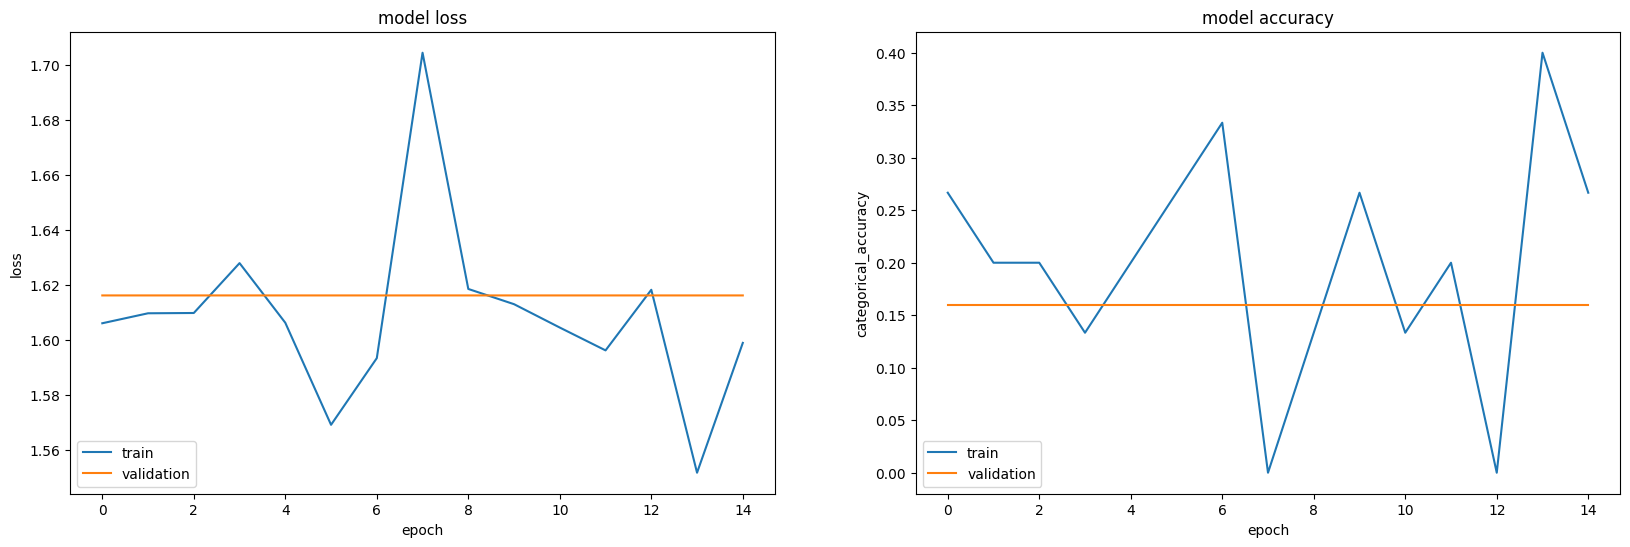

In [ ]:
# fit_model(model_resnet_lstm, 'resnet50_lstm')

## ResNet50 (10 trainable layers) + LSTM

In [ ]:
# # Load pre-trained ResNet50 model without the top layers
# base_model4 = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model4.layers:
#     layer.trainable = False

# for layer in base_model4.layers[-10:]:
#     layer.trainable = True

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x4 = TimeDistributed(base_model4)(inputs)
# x4 = TimeDistributed(GlobalAveragePooling2D())(x4)

# # Add an LSTM layer for sequence learning
# x4 = LSTM(128)(x4)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x4)

# # Compile the model
# model_resnet_lstm4 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                             

Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.68514, saving model to /tmp/models/model_resnet_lstm4_2023-04-2422_40_45.024786/best_model.h5
3/3 - 16s - loss: 1.4962 - categorical_accuracy: 0.3545 - val_loss: 1.6851 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 16s/epoch - 5s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.68514 to 1.68308, saving model to /tmp/models/model_resnet_lstm4_2023-04-2422_40_45.024786/best_model.h5
3/3 - 12s - loss: 1.3665 - categorical_accuracy: 0.4762 - val_loss: 1.6831 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.68308
3/3 - 11s - loss: 1.2816 - categorical_accuracy: 0.5132 - val_loss: 1.6869 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 11s/epoch - 4s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.68308 to 1.67952, saving model to /tmp/models/model_resnet_lstm4_2023-04-2422_40_45.024786

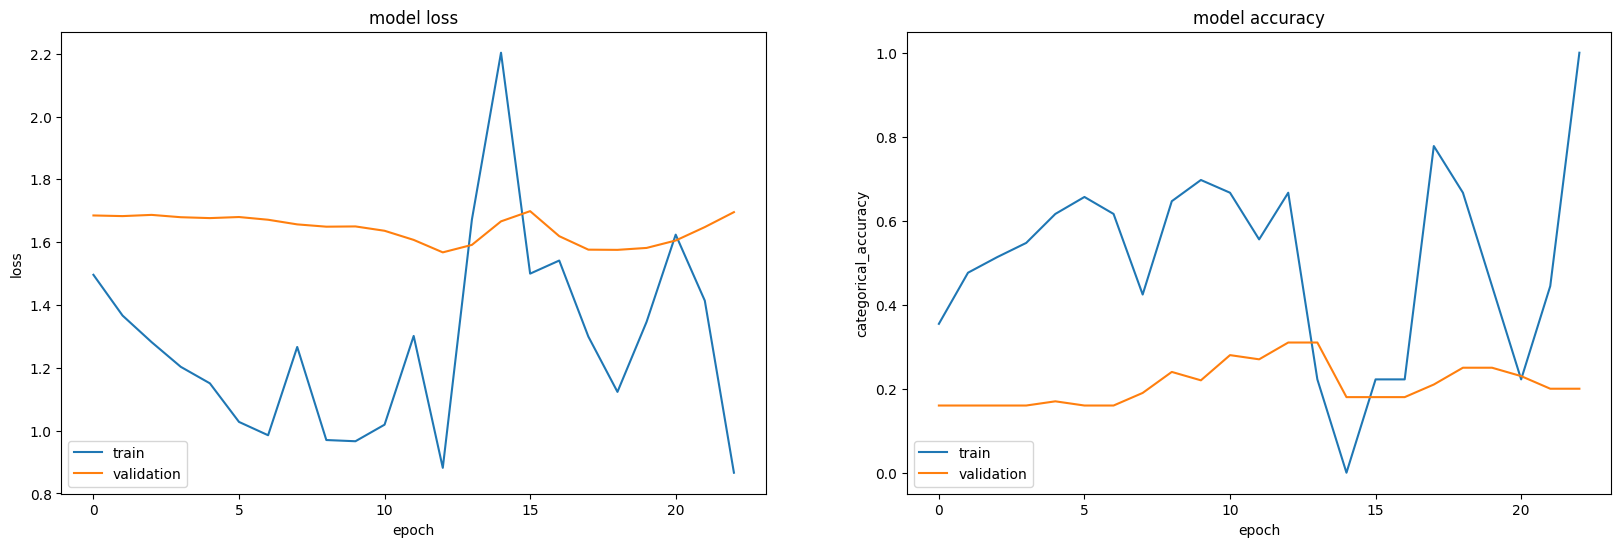

In [ ]:
# fit_model(model_resnet_lstm4, 'model_resnet_lstm4')

## ResNet50(20 trainable layers) + LSTM

In [ ]:
# # Load pre-trained ResNet50 model without the top layers
# base_model5 = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model5.layers:
#     layer.trainable = False

# for layer in base_model5.layers[-20:]:
#     layer.trainable = True

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x5 = TimeDistributed(base_model5)(inputs)
# x5 = TimeDistributed(GlobalAveragePooling2D())(x5)

# # Add an LSTM layer for sequence learning
# x5 = LSTM(128)(x5)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x5)

# # Compile the model
# model_resnet_lstm5 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.70417, saving model to /tmp/models/model_resnet_lstm5_2023-04-2422_50_43.424537/best_model.h5
3/3 - 39s - loss: 1.5301 - categorical_accuracy: 0.3243 - val_loss: 1.7042 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 39s/epoch - 13s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.70417 to 1.69672, saving model to /tmp/models/model_resnet_lstm5_2023-04-2422_50_43.424537/best_model.h5
3/3 - 12s - loss: 1.1700 - categorical_accuracy: 0.5450 - val_loss: 1.6967 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.69672
3/3 - 11s - loss: 1.0851 - categorical_accuracy: 0.6349 - val_loss: 1.7116 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 11s/epoch - 4s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.69672
3/3 - 11s - loss: 

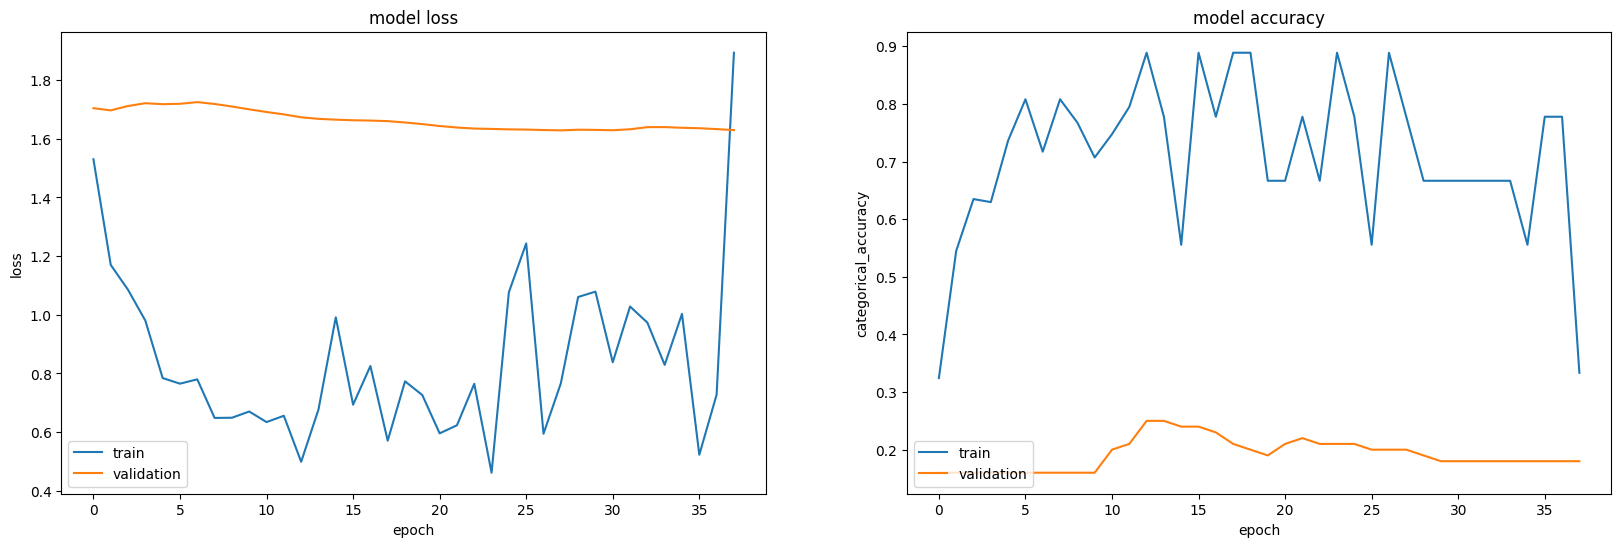

In [ ]:
# fit_model(model_resnet_lstm5, 'model_resnet_lstm5')

## ResNet50 (20 trainable layers) + More LSTM Units

In [ ]:
# # Load pre-trained ResNet50 model without the top layers
# base_model6 = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model6.layers:
#     layer.trainable = False

# for layer in base_model6.layers[-20:]:
#     layer.trainable = True

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x6 = TimeDistributed(base_model6)(inputs)
# x6 = TimeDistributed(GlobalAveragePooling2D())(x6)

# # Add an LSTM layer for sequence learning
# x6 = LSTM(256)(x6)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x6)

# # Compile the model
# model_resnet_lstm6 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               2360320   
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.63421, saving model to /tmp/models/model_resnet_lstm6_2023-04-2423_08_44.413748/best_model.h5
3/3 - 39s - loss: 1.5137 - categorical_accuracy: 0.3122 - val_loss: 1.6342 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 39s/epoch - 13s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.63421 to 1.63328, saving model to /tmp/models/model_resnet_lstm6_2023-04-2423_08_44.413748/best_model.h5
3/3 - 12s - loss: 1.1389 - categorical_accuracy: 0.5767 - val_loss: 1.6333 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.63328
3/3 - 11s - loss: 1.0787 - categorical_accuracy: 0.6138 - val_loss: 1.6467 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 11s/epoch - 4s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.63328
3/3 - 11s - loss: 

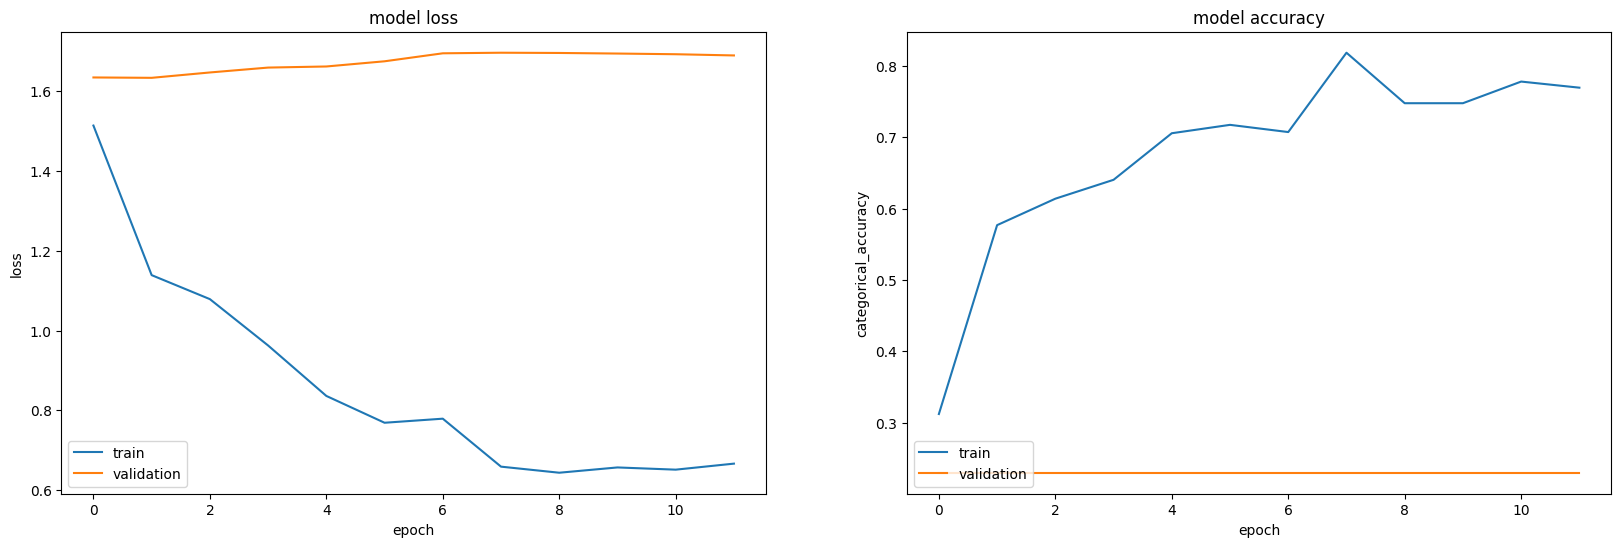

In [ ]:
# fit_model(model_resnet_lstm6, 'model_resnet_lstm6')

## Dropout Layer with Previous Model

In [ ]:
# # Load pre-trained ResNet50 model without the top layers
# base_model7 = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model7.layers:
#     layer.trainable = False

# for layer in base_model7.layers[-20:]:
#     layer.trainable = True

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x7 = TimeDistributed(base_model7)(inputs)
# x7 = TimeDistributed(GlobalAveragePooling2D())(x7)

# # Add an LSTM layer for sequence learning
# x7 = LSTM(256)(x7)
# x7 = Dropout(0.5)(x7)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x7)

# # Compile the model
# model_resnet_lstm7 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               2360320   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.63562, saving model to /tmp/models/model_resnet_lstm_2023-04-2423_17_10.642066/best_model.h5
3/3 - 39s - loss: 1.5909 - categorical_accuracy: 0.2911 - val_loss: 1.6356 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 39s/epoch - 13s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.63562 to 1.63399, saving model to /tmp/models/model_resnet_lstm_2023-04-2423_17_10.642066/best_model.h5
3/3 - 12s - loss: 1.2504 - categorical_accuracy: 0.4815 - val_loss: 1.6340 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.63399
3/3 - 11s - loss: 1.2083 - categorical_accuracy: 0.4974 - val_loss: 1.6414 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 11s/epoch - 4s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.63399
3/3 - 11s - loss: 1.

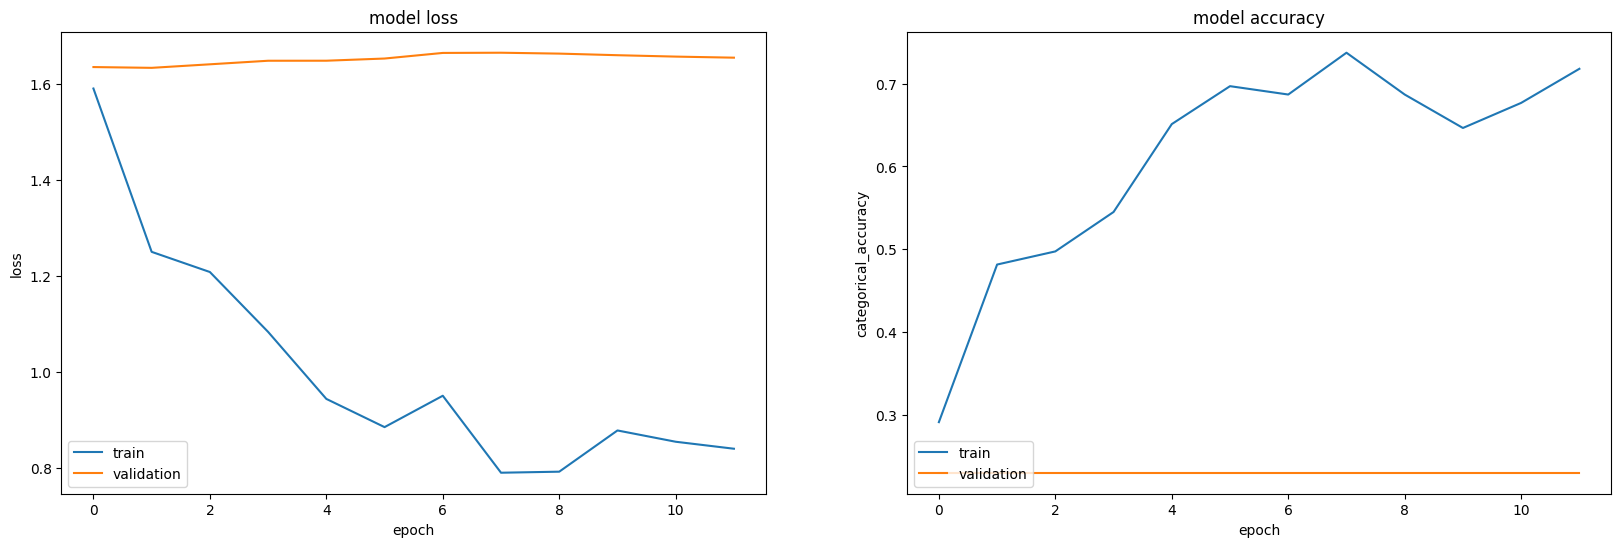

In [ ]:
# fit_model(model_resnet_lstm7, 'model_resnet_lstm')

## ResNet50 (30 Trainable Layers) + LSTM

In [18]:
# # Load pre-trained ResNet50 model without the top layers
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model.layers:
#     layer.trainable = False

# for layer in base_model.layers[-30:]:
#     layer.trainable = True

In [19]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an LSTM layer for sequence learning
# x = LSTM(56)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_lstm5 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 56)                471520    
                                                                 
 dense (Dense)               (None, 5)                 285       
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.68940, saving model to /tmp/models/model_resnet_lstm5_2023-04-2500_29_50.730782/best_model.h5
3/3 - 42s - loss: 1.5081 - categorical_accuracy: 0.3167 - val_loss: 1.6894 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 42s/epoch - 14s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.68940 to 1.67188, saving model to /tmp/models/model_resnet_lstm5_2023-04-2500_29_50.730782/best_model.h5
3/3 - 12s - loss: 1.2148 - categorical_accuracy: 0.5450 - val_loss: 1.6719 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.67188
3/3 - 11s - loss: 1.1311 - categorical_accuracy: 0.6085 - val_loss: 1.6736 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 11s/epoch - 4s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.67188 to 1.66938, saving model 

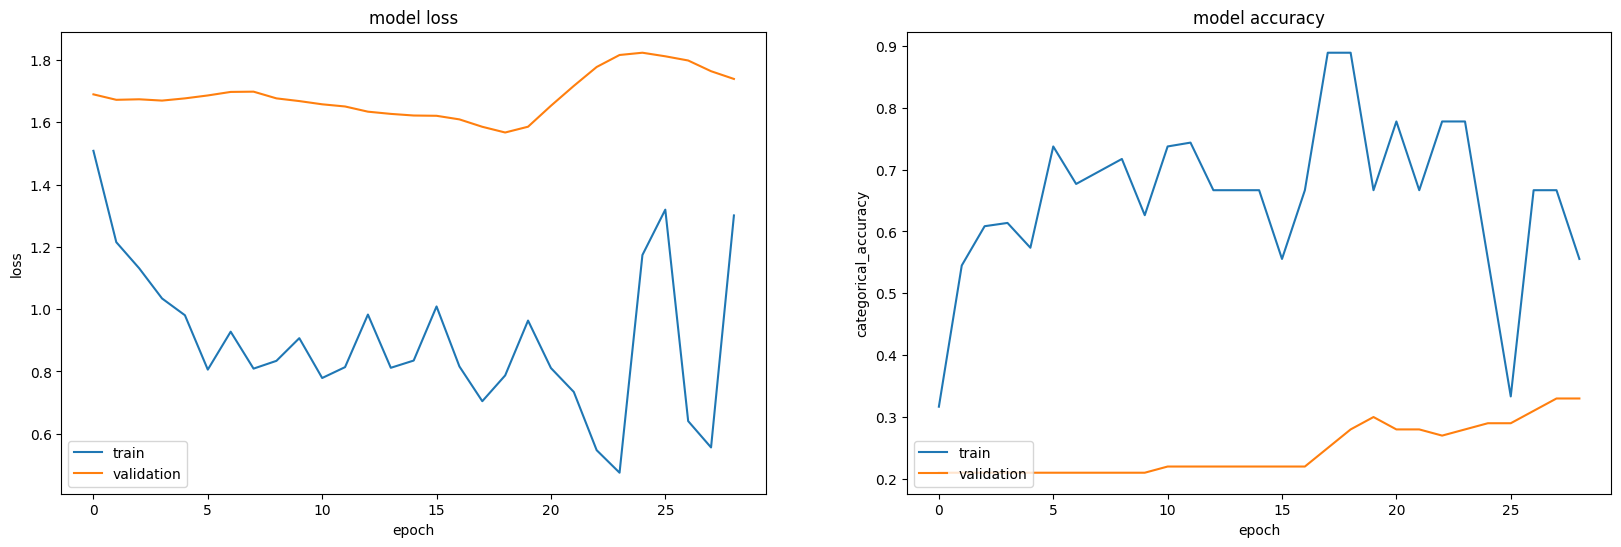

In [20]:
# fit_model(model_resnet_lstm5, 'model_resnet_lstm5')

## ResNet50 (30 Trainable Layers) + More LSTM Units

In [25]:
# Load pre-trained ResNet50 model without the top layers
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(120,120,3)
)

# Set the base model layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

94765736/94765736 [==============================] - 5s 0us/step


In [26]:
inputs = Input(shape=input_shape)

# Extract features for each frame using ResNet50
x = TimeDistributed(base_model)(inputs)
x = TimeDistributed(GlobalAveragePooling2D())(x)

# Add an LSTM layer for sequence learning
x = LSTM(128)(x)

# Add a Dense layer for classification
outputs = Dense(5, activation='softmax')(x)

# Compile the model
model_resnet_lstm = Model(inputs=inputs, outputs=outputs)
model_resnet_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_resnet_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.64864, saving model to /tmp/models/model_resnet_lstm_2023-04-2500_01_27.036210/best_model.h5
3/3 - 42s - loss: 1.6247 - categorical_accuracy: 0.2881 - val_loss: 1.6486 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 42s/epoch - 14s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.64864 to 1.64273, saving model to /tmp/models/model_resnet_lstm_2023-04-2500_01_27.036210/best_model.h5
3/3 - 12s - loss: 1.2333 - categorical_accuracy: 0.4868 - val_loss: 1.6427 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.64273 to 1.64205, saving model to /tmp/models/model_resnet_lstm_2023-04-2500_01_27.036210/best_model.h5
3/3 - 12s - loss: 1.1336 - categorical_accuracy: 0.5873 - val_loss: 1.6420 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04 - 12s/epoch

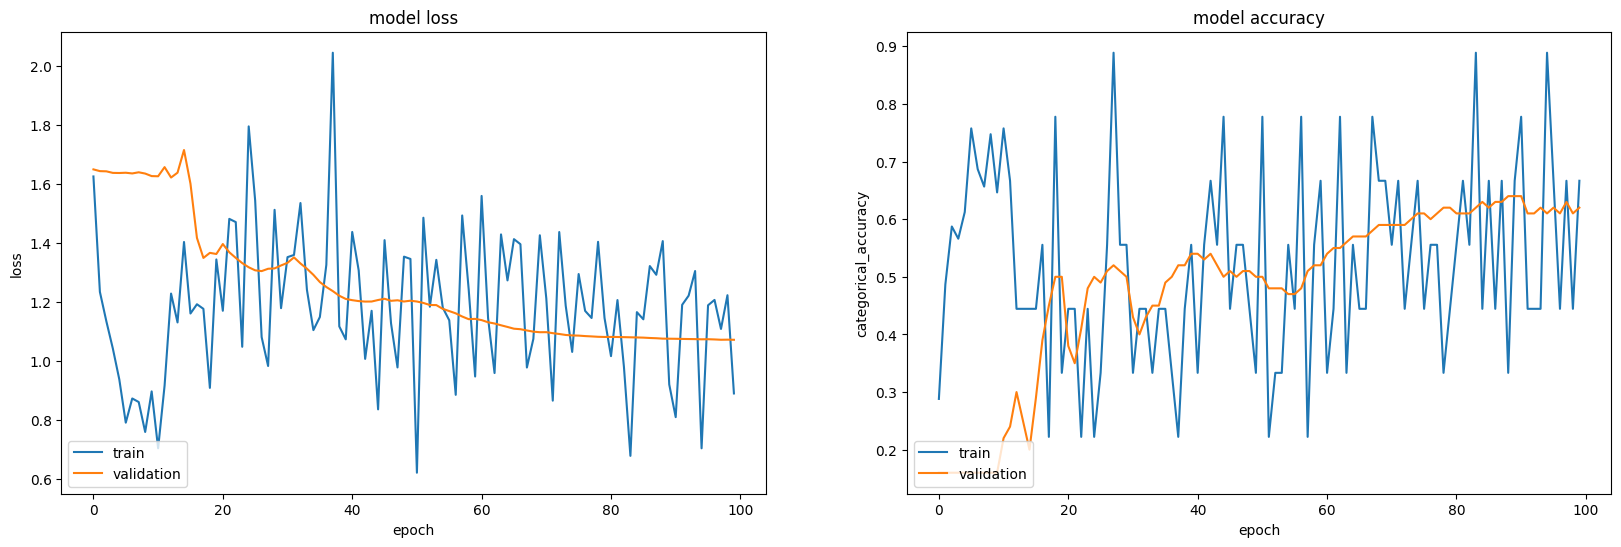

In [21]:
# Without Augmentation
fit_model(model_resnet_lstm, 'model_resnet_lstm')

Epoch 101/200

Epoch 101: val_loss improved from inf to 1.07077, saving model to /tmp/models/model_resnet_lstm_2023-04-2500_01_27.036210/best_model.h5
3/3 - 8s - loss: 0.6710 - categorical_accuracy: 0.8889 - val_loss: 1.0708 - val_categorical_accuracy: 0.6000 - lr: 8.0000e-07 - 8s/epoch - 3s/step
Epoch 102/200

Epoch 102: val_loss improved from 1.07077 to 1.07056, saving model to /tmp/models/model_resnet_lstm_2023-04-2500_01_27.036210/best_model.h5
3/3 - 8s - loss: 1.0145 - categorical_accuracy: 0.6667 - val_loss: 1.0706 - val_categorical_accuracy: 0.6200 - lr: 8.0000e-07 - 8s/epoch - 3s/step
Epoch 103/200

Epoch 103: val_loss did not improve from 1.07056
3/3 - 7s - loss: 1.8605 - categorical_accuracy: 0.2222 - val_loss: 1.0707 - val_categorical_accuracy: 0.6100 - lr: 8.0000e-07 - 7s/epoch - 2s/step
Epoch 104/200

Epoch 104: val_loss improved from 1.07056 to 1.07014, saving model to /tmp/models/model_resnet_lstm_2023-04-2500_01_27.036210/best_model.h5
3/3 - 8s - loss: 1.1150 - categori

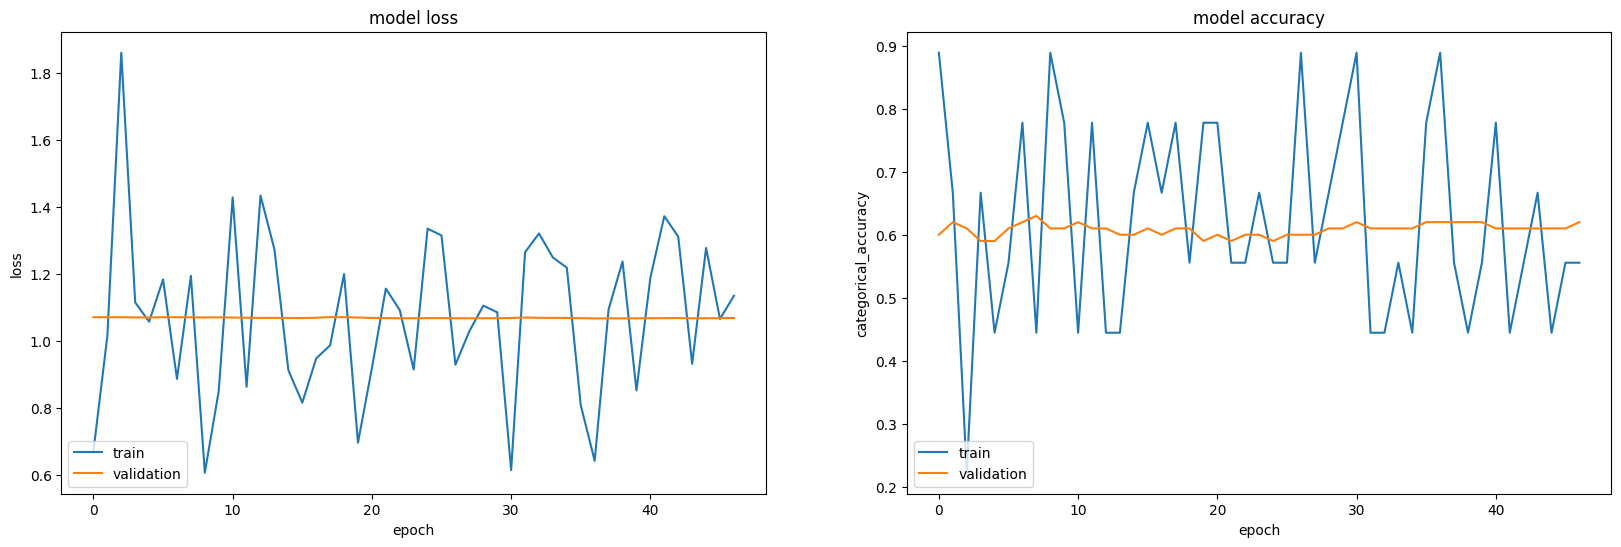

In [23]:
# Training further
history = model_resnet_lstm.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=200, initial_epoch=100, verbose=2,
                    callbacks=getCallbacks('model_resnet_lstm'), validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None)
plot_perf(history)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.64422, saving model to /tmp/models/model_resnet_lstm_2023-04-2510_42_36.974721/best_model.h5
5/5 - 19s - loss: 1.8089 - categorical_accuracy: 0.1000 - val_loss: 1.6442 - val_categorical_accuracy: 0.2200 - lr: 6.4000e-09 - 19s/epoch - 4s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.64422 to 1.64243, saving model to /tmp/models/model_resnet_lstm_2023-04-2510_42_36.974721/best_model.h5
5/5 - 9s - loss: 1.6175 - categorical_accuracy: 0.3667 - val_loss: 1.6424 - val_categorical_accuracy: 0.2200 - lr: 6.4000e-09 - 9s/epoch - 2s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.64243 to 1.64116, saving model to /tmp/models/model_resnet_lstm_2023-04-2510_42_36.974721/best_model.h5
5/5 - 9s - loss: 1.6998 - categorical_accuracy: 0.1667 - val_loss: 1.6412 - val_categorical_accuracy: 0.2200 - lr: 6.4000e-09 - 9s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.64116 to 1.63689, saving model to /tmp/models/model_resnet_ls

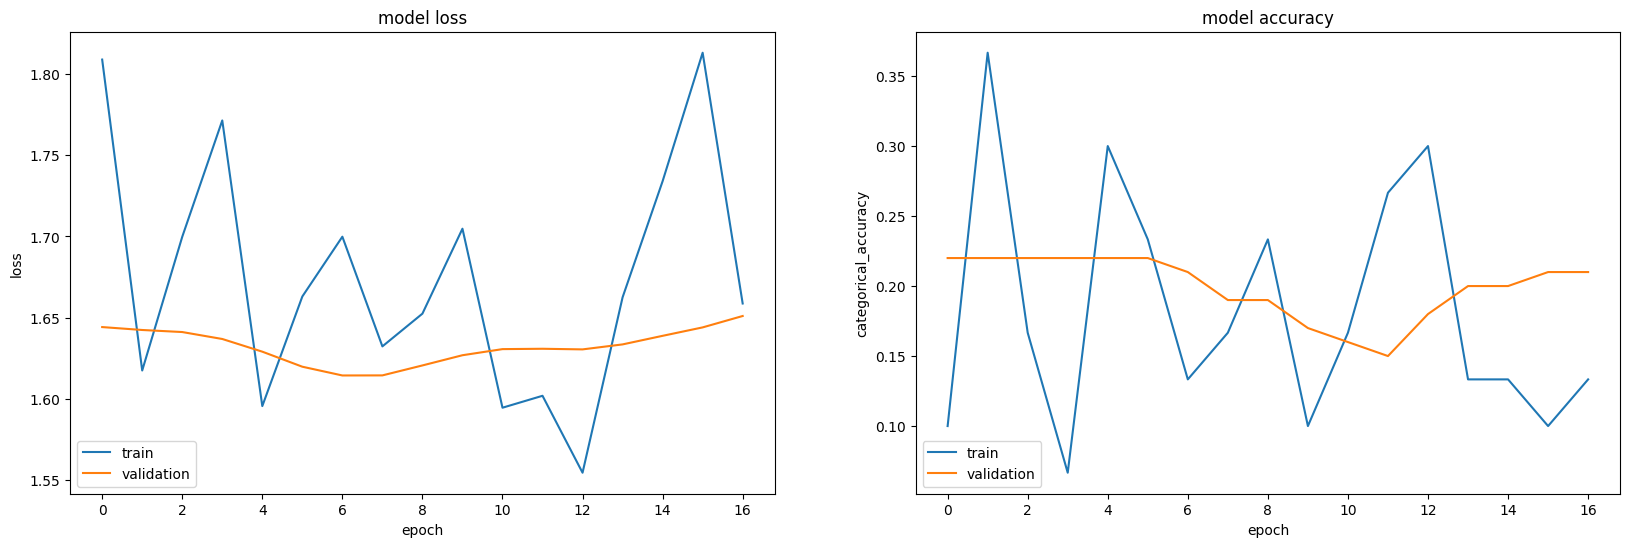

In [27]:
# With Augmentation
fit_model(model_resnet_lstm, 'model_resnet_lstm')

## ResNet50 (30 trainable layers) + More LSTM Units

In [ ]:
# # Load pre-trained ResNet50 model without the top layers
# base_model8 = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model8.layers:
#     layer.trainable = False

# for layer in base_model8.layers[-30:]:
#     layer.trainable = True

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x8 = TimeDistributed(base_model8)(inputs)
# x8 = TimeDistributed(GlobalAveragePooling2D())(x8)

# # Add an LSTM layer for sequence learning
# x8 = LSTM(256)(x8)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x8)

# # Compile the model
# model_resnet_lstm8 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm8.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               2360320   
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.66346, saving model to /tmp/models/model_resnet_lstm8_2023-04-2423_24_26.367685/best_model.h5
3/3 - 42s - loss: 1.6071 - categorical_accuracy: 0.2398 - val_loss: 1.6635 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 42s/epoch - 14s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.66346 to 1.65671, saving model to /tmp/models/model_resnet_lstm8_2023-04-2423_24_26.367685/best_model.h5
3/3 - 12s - loss: 1.2566 - categorical_accuracy: 0.5238 - val_loss: 1.6567 - val_categorical_accuracy: 0.2700 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.65671 to 1.65543, saving model to /tmp/models/model_resnet_lstm8_2023-04-2423_24_26.367685/best_model.h5
3/3 - 12s - loss: 1.1592 - categorical_accuracy: 0.5503 - val_loss: 1.6554 - val_categorical_accuracy: 0.2700 - lr: 1.0000e-04 - 12s/ep

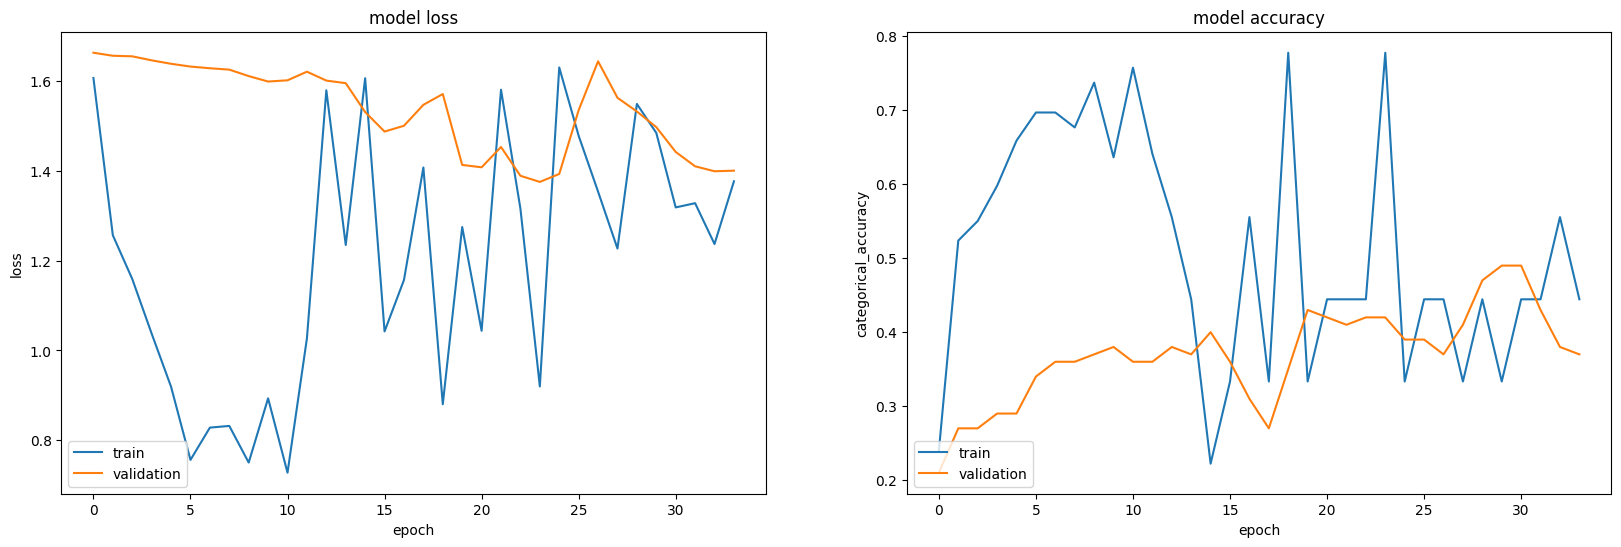

In [ ]:
# fit_model(model_resnet_lstm8, 'model_resnet_lstm8')

## ResNet50 (30 Trainable Layers) + Even More LSTM units

In [ ]:
# # Load pre-trained ResNet50 model without the top layers
# base_model9 = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model9.layers:
#     layer.trainable = False

# for layer in base_model9.layers[-30:]:
#     layer.trainable = True

In [ ]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x9 = TimeDistributed(base_model9)(inputs)
# x9 = TimeDistributed(GlobalAveragePooling2D())(x9)

# # Add an LSTM layer for sequence learning
# x9 = LSTM(512)(x9)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x9)

# # Compile the model
# model_resnet_lstm9 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm9.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 512)               5244928   
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.63916, saving model to /tmp/models/model_resnet_lstm9_2023-04-2423_36_19.340554/best_model.h5
3/3 - 42s - loss: 1.5809 - categorical_accuracy: 0.3228 - val_loss: 1.6392 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04 - 42s/epoch - 14s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.63916 to 1.63474, saving model to /tmp/models/model_resnet_lstm9_2023-04-2423_36_19.340554/best_model.h5
3/3 - 12s - loss: 1.1903 - categorical_accuracy: 0.5450 - val_loss: 1.6347 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.63474 to 1.63158, saving model to /tmp/models/model_resnet_lstm9_2023-04-2423_36_19.340554/best_model.h5
3/3 - 12s - loss: 1.1026 - categorical_accuracy: 0.5556 - val_loss: 1.6316 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04 - 12s/ep

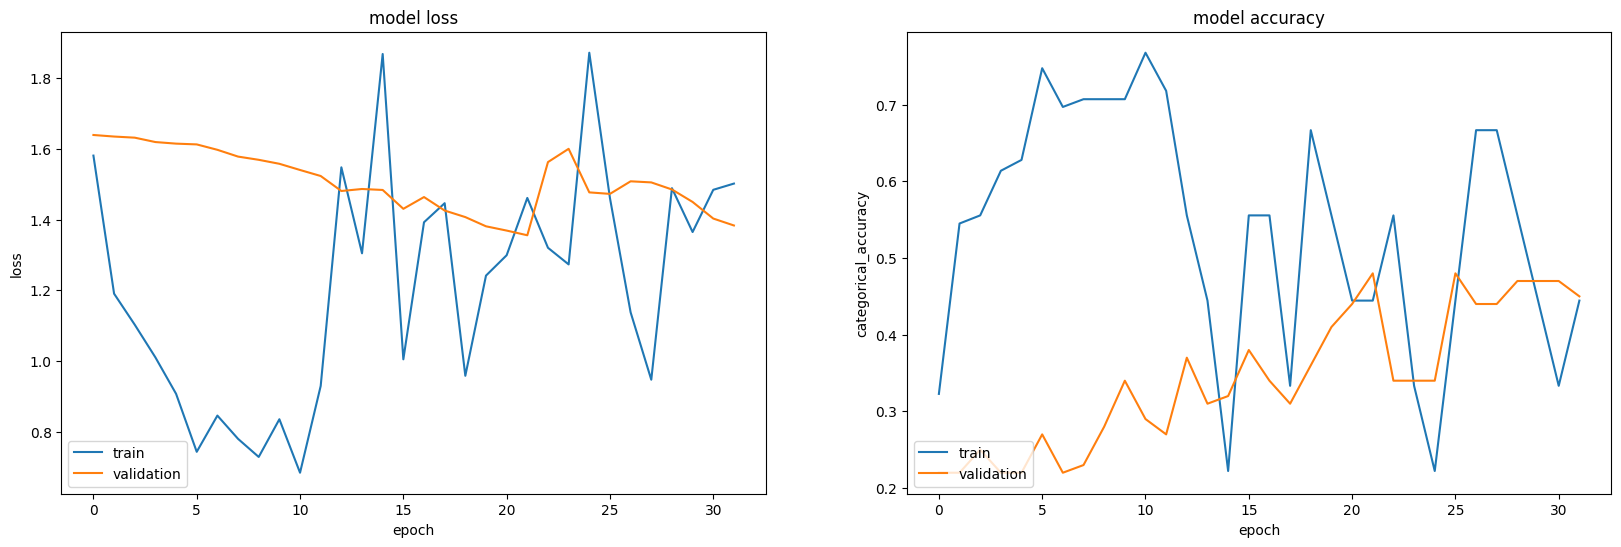

In [ ]:
# fit_model(model_resnet_lstm9, 'model_resnet_lstm9')

## ResNet50 (30 Trainable Layers) + Even More LSTM units

In [18]:
# # Load pre-trained ResNet50 model without the top layers
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model.layers:
#     layer.trainable = False

# for layer in base_model.layers[-30:]:
#     layer.trainable = True

In [19]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an LSTM layer for sequence learning
# x = LSTM(1024)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_lstm6 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 1024)              12587008  
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                             

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.09071, saving model to /tmp/models/model_resnet_lstm6_2023-04-2423_46_37.313300/best_model.h5
3/3 - 8s - loss: 1.0105 - categorical_accuracy: 0.5556 - val_loss: 1.0907 - val_categorical_accuracy: 0.5700 - lr: 4.0000e-06 - 8s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.09071 to 1.08518, saving model to /tmp/models/model_resnet_lstm6_2023-04-2423_46_37.313300/best_model.h5
3/3 - 8s - loss: 0.8616 - categorical_accuracy: 0.6667 - val_loss: 1.0852 - val_categorical_accuracy: 0.6000 - lr: 4.0000e-06 - 8s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.08518 to 1.07917, saving model to /tmp/models/model_resnet_lstm6_2023-04-2423_46_37.313300/best_model.h5
3/3 - 8s - loss: 1.4776 - categorical_accuracy: 0.4444 - val_loss: 1.0792 - val_categorical_accuracy: 0.6000 - lr: 4.0000e-06 - 8s/epoch - 3s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.07917 to 1.07795, saving model to /tmp/models/model_resnet_l

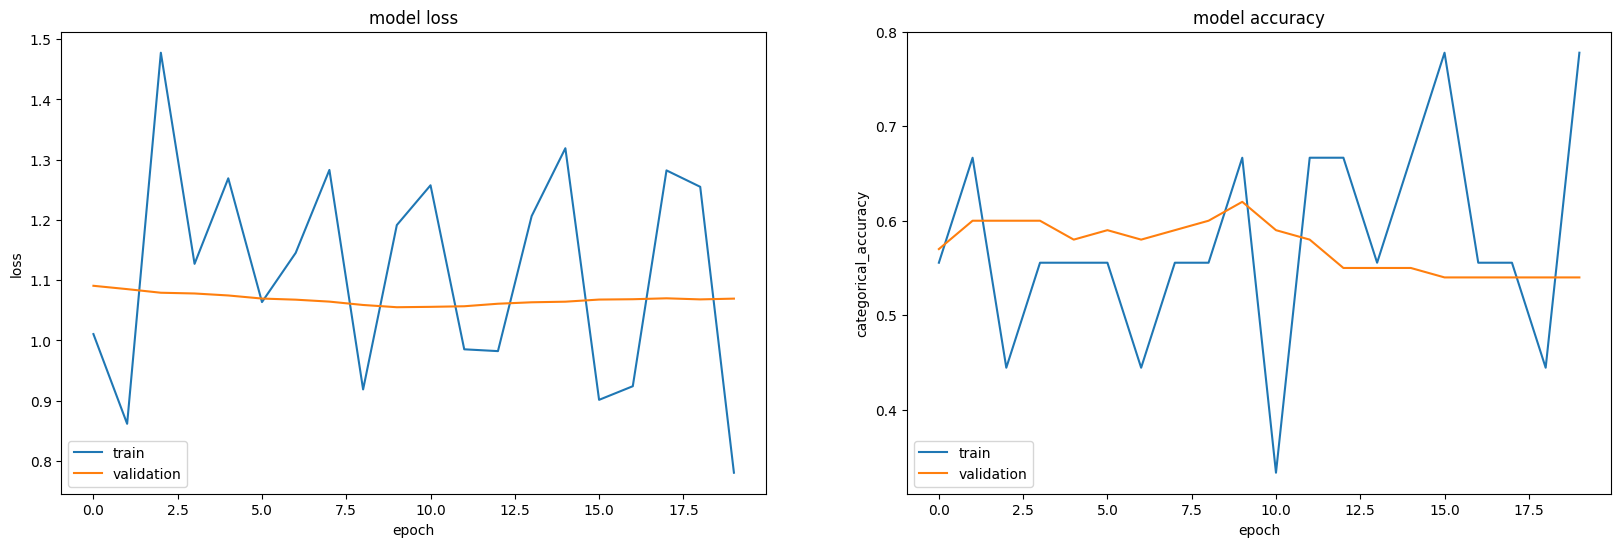

In [21]:
# fit_model(model_resnet_lstm6, 'model_resnet_lstm6')

## ResNet50 (40 trainable layers) + LSTM

In [18]:
# # Load pre-trained ResNet50 model without the top layers
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model.layers:
#     layer.trainable = False

# for layer in base_model.layers[-40:]:
#     layer.trainable = True

In [19]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an LSTM layer for sequence learning
# x = LSTM(128)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_lstm4 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                             

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.60523, saving model to /tmp/models/model_resnet_lstm4_2023-04-2500_37_21.479546/best_model.h5
3/3 - 8s - loss: 0.9354 - categorical_accuracy: 0.5556 - val_loss: 1.6052 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-05 - 8s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.60523 to 1.60027, saving model to /tmp/models/model_resnet_lstm4_2023-04-2500_37_21.479546/best_model.h5
3/3 - 8s - loss: 0.9315 - categorical_accuracy: 0.7778 - val_loss: 1.6003 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-05 - 8s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.60027 to 1.55100, saving model to /tmp/models/model_resnet_lstm4_2023-04-2500_37_21.479546/best_model.h5
3/3 - 8s - loss: 1.0850 - categorical_accuracy: 0.5556 - val_loss: 1.5510 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-05 - 8s/epoch - 3s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.55100 to 1.49475, saving model to /tmp/models/model_resnet_l

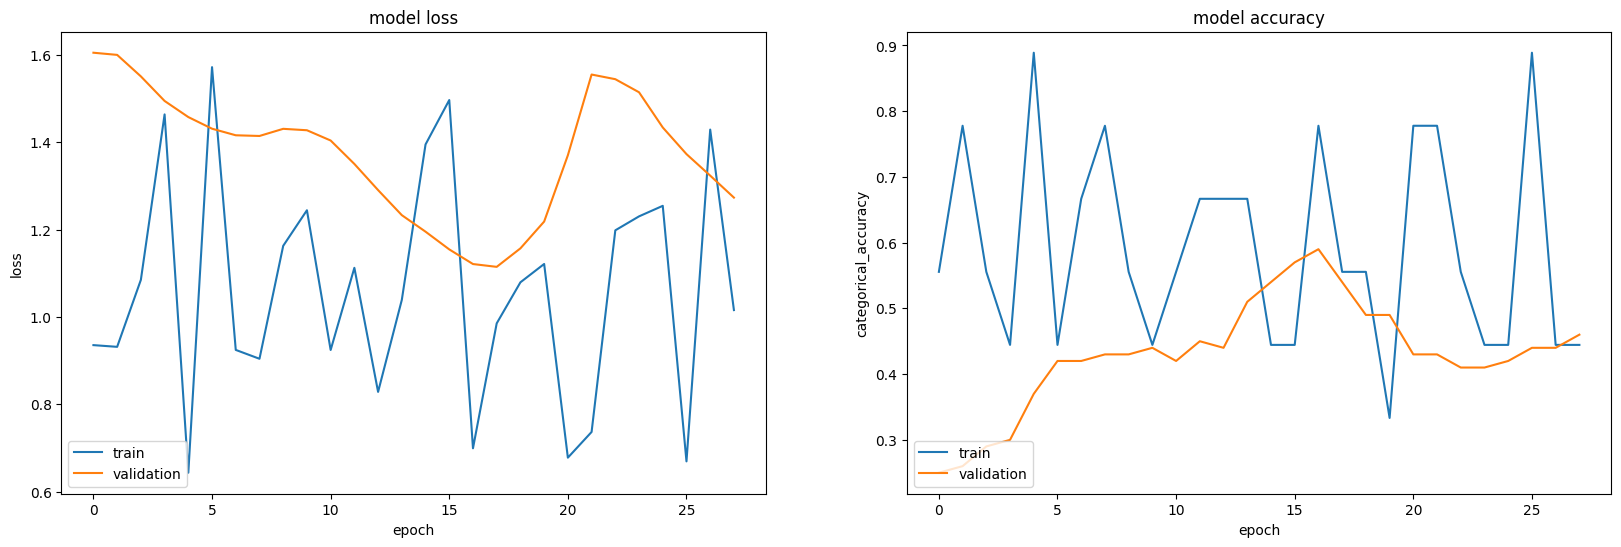

In [21]:
# fit_model(model_resnet_lstm4, 'model_resnet_lstm4')

## ResNet50 (Completely Trainable) + LSTM

In [17]:
# # Load pre-trained ResNet50 model without the top layers
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Train the head first
# base_model.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [18]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an LSTM layer for sequence learning
# x = LSTM(128)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_lstm6 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                             

Source path =  /tmp/Project_data/train ; batch size = 100
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 100

Epoch 1: val_loss improved from inf to 1.62548, saving model to /tmp/models/model_resnet_lstm6_2023-04-2509_14_09.190020/best_model.h5
7/7 - 50s - loss: 1.6753 - categorical_accuracy: 0.2051 - val_loss: 1.6255 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-04 - 50s/epoch - 7s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.62548 to 1.60491, saving model to /tmp/models/model_resnet_lstm6_2023-04-2509_14_09.190020/best_model.h5
7/7 - 22s - loss: 1.6178 - categorical_accuracy: 0.2063 - val_loss: 1.6049 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 22s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.60491 to 1.60020, saving model to /tmp/models/model_resnet_lstm6_2023-04-2509_14_09.190020/best_model.h5
7/7 - 18s - loss: 1.6079 - categorical_accuracy: 0.2056 - val_loss: 1.6002 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04 - 18s/epo

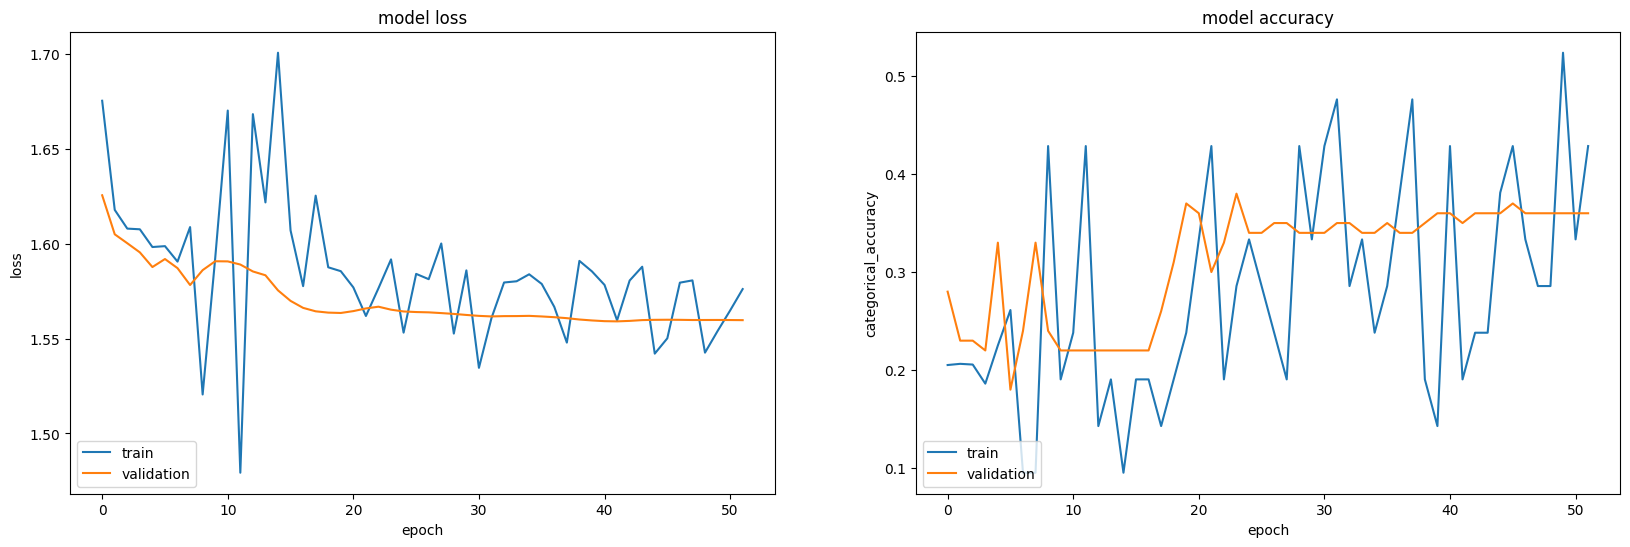

In [19]:
# fit_model(model_resnet_lstm6, 'model_resnet_lstm6')

In [20]:
# base_model.trainable = True

In [21]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an LSTM layer for sequence learning
# x = LSTM(128)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_lstm6 = Model(inputs=inputs, outputs=outputs)
# model_resnet_lstm6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_lstm6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 128)               1114624   
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                           

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.65620, saving model to /tmp/models/model_resnet_lstm6_2023-04-2509_14_09.190020/best_model.h5
7/7 - 23s - loss: 1.6613 - categorical_accuracy: 0.1429 - val_loss: 1.6562 - val_categorical_accuracy: 0.1600 - lr: 1.6000e-07 - 23s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.65620
7/7 - 8s - loss: 1.6226 - categorical_accuracy: 0.2381 - val_loss: 1.6584 - val_categorical_accuracy: 0.1600 - lr: 1.6000e-07 - 8s/epoch - 1s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.65620
7/7 - 8s - loss: 1.6403 - categorical_accuracy: 0.2381 - val_loss: 1.7067 - val_categorical_accuracy: 0.1600 - lr: 1.6000e-07 - 8s/epoch - 1s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.65620
7/7 - 8s - loss: 1.7778 - categorical_accuracy: 0.1429 - val_loss: 1.7513 - val_categorical_accuracy: 0.1600 - lr: 1.6000e-07 - 8s/epoch - 1s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.65620
7/7 - 8s - loss: 1.638

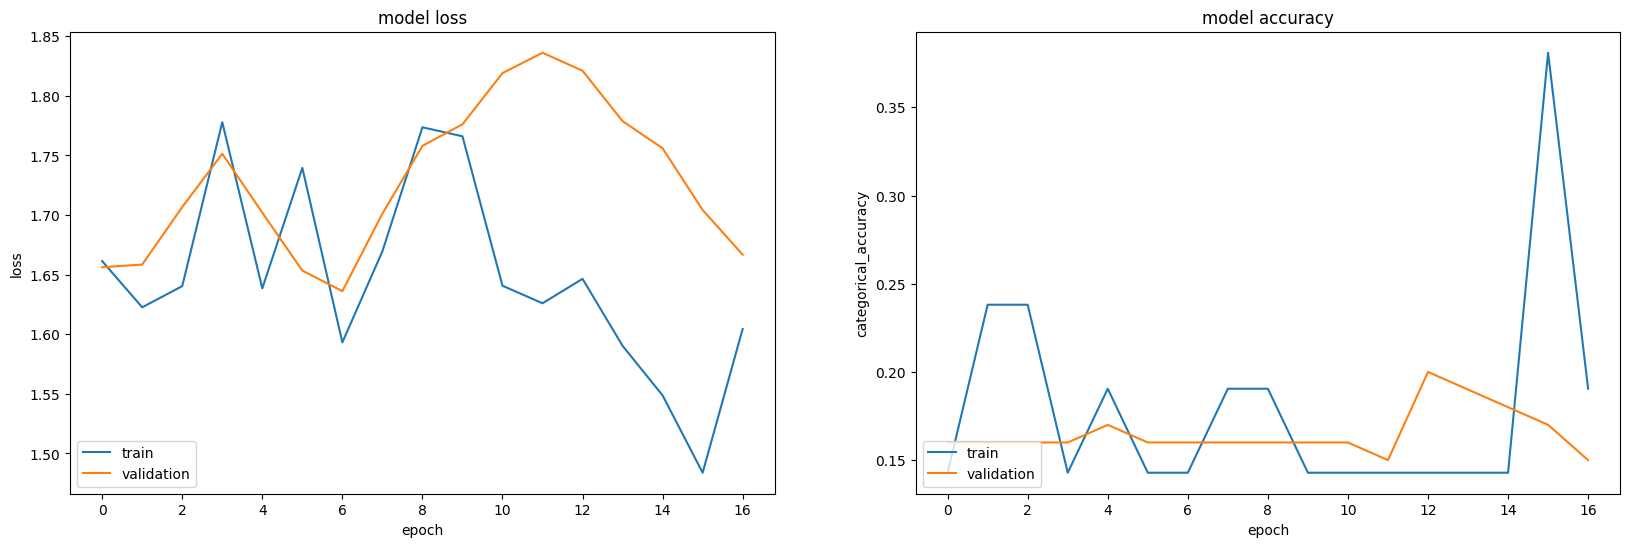

In [22]:
# fit_model(model_resnet_lstm6, 'model_resnet_lstm6')

## ResNet50 (30 trainable layers) + GRU

In [18]:
# # Load pre-trained ResNet50 model without the top layers
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(120,120,3)
# )

# # Set the base model layers to non-trainable
# for layer in base_model.layers:
#     layer.trainable = False

# for layer in base_model.layers[-30:]:
#     layer.trainable = True

In [19]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an GRU layer for sequence learning
# x = GRU(128)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_gru = Model(inputs=inputs, outputs=outputs)
# model_resnet_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_gru.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               836352    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                             

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.70053, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 42s - loss: 1.6997 - categorical_accuracy: 0.3228 - val_loss: 1.7005 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 42s/epoch - 14s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.70053 to 1.69518, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 12s - loss: 1.0816 - categorical_accuracy: 0.6296 - val_loss: 1.6952 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 12s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.69518 to 1.68747, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 12s - loss: 1.0192 - categorical_accuracy: 0.6402 - val_loss: 1.6875 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 12s/epoch - 

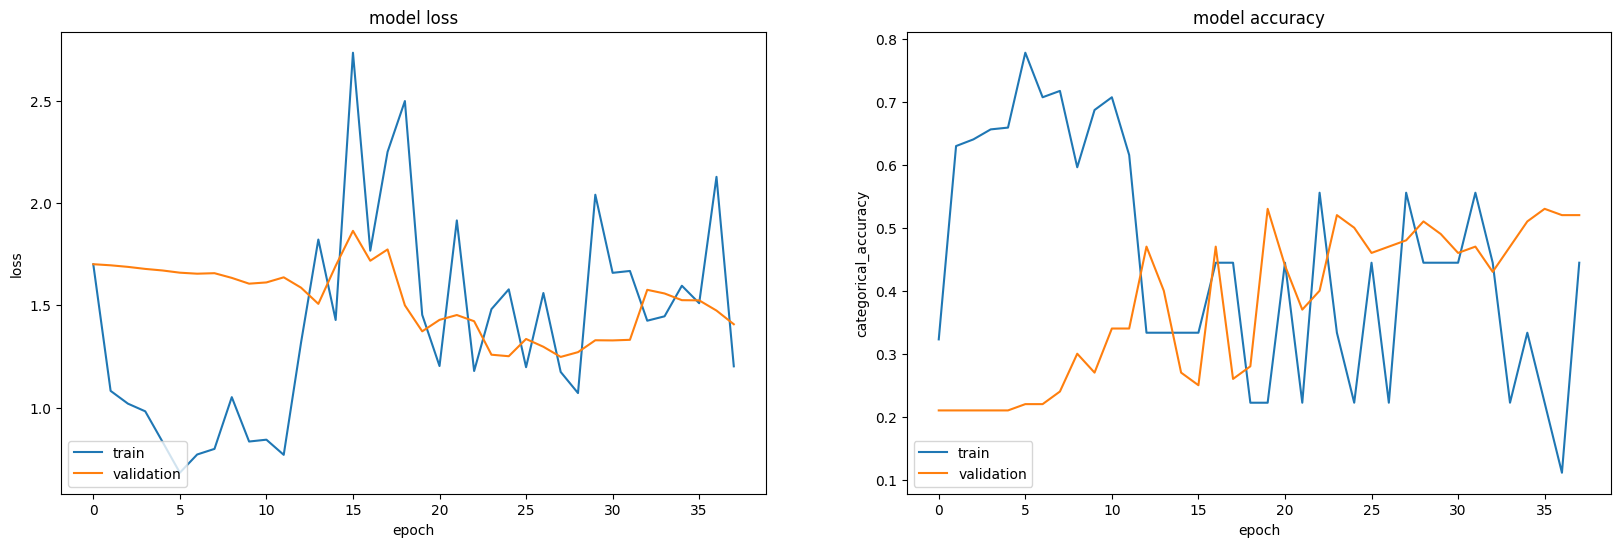

In [20]:
# # Without Augmentation
# fit_model(model_resnet_gru, 'model_resnet_gru')

Source path =  /tmp/Project_data/train ; batch size = 300
Epoch 1/100
Source path =  /tmp/Project_data/val ; batch size = 300

Epoch 1: val_loss improved from inf to 1.70829, saving model to /tmp/models/model_resnet_gru_2023-04-2511_28_42.522897/best_model.h5
5/5 - 70s - loss: 1.7431 - categorical_accuracy: 0.2587 - val_loss: 1.7083 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 70s/epoch - 14s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.70829 to 1.69752, saving model to /tmp/models/model_resnet_gru_2023-04-2511_28_42.522897/best_model.h5
5/5 - 27s - loss: 1.3882 - categorical_accuracy: 0.4079 - val_loss: 1.6975 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 27s/epoch - 5s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.69752 to 1.68750, saving model to /tmp/models/model_resnet_gru_2023-04-2511_28_42.522897/best_model.h5
5/5 - 27s - loss: 1.2965 - categorical_accuracy: 0.4349 - val_loss: 1.6875 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04 - 27s/epoch - 

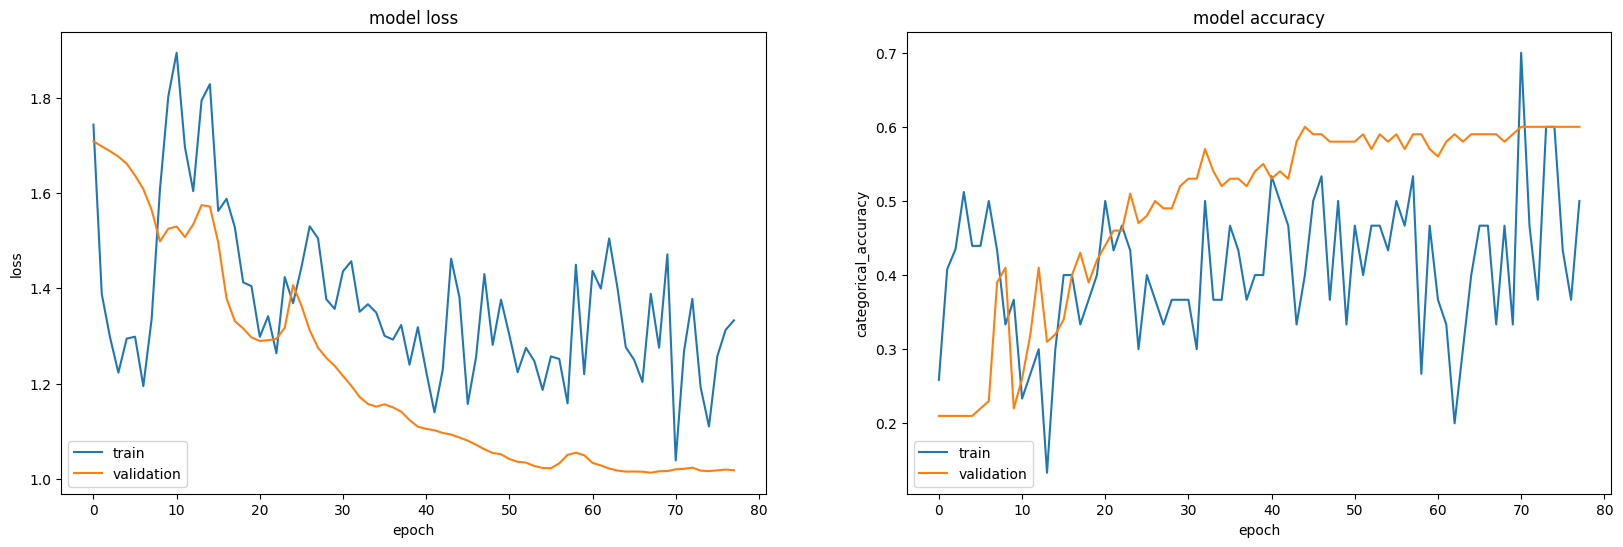

In [20]:
# # With Augmentation
# fit_model(model_resnet_gru, 'model_resnet_gru')

## ResNet50 (30 Trainable Layers) + More GRU Units

In [21]:
# inputs = Input(shape=input_shape)

# # Extract features for each frame using ResNet50
# x = TimeDistributed(base_model)(inputs)
# x = TimeDistributed(GlobalAveragePooling2D())(x)

# # Add an GRU layer for sequence learning
# x = GRU(512)(x)

# # Add a Dense layer for classification
# outputs = Dense(5, activation='softmax')(x)

# # Compile the model
# model_resnet_gru = Model(inputs=inputs, outputs=outputs)
# model_resnet_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model_resnet_gru.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 512)               3935232   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                           

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.71081, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 17s - loss: 2.0322 - categorical_accuracy: 0.0000e+00 - val_loss: 1.7108 - val_categorical_accuracy: 0.1400 - lr: 4.0000e-06 - 17s/epoch - 6s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.71081 to 1.69360, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 8s - loss: 1.6789 - categorical_accuracy: 0.2222 - val_loss: 1.6936 - val_categorical_accuracy: 0.1500 - lr: 4.0000e-06 - 8s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.69360 to 1.68209, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 8s - loss: 1.6736 - categorical_accuracy: 0.1111 - val_loss: 1.6821 - val_categorical_accuracy: 0.1800 - lr: 4.0000e-06 - 8s/epoch - 3s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.68209 to 1.66767, saving model to /tmp/models/model_resnet_g

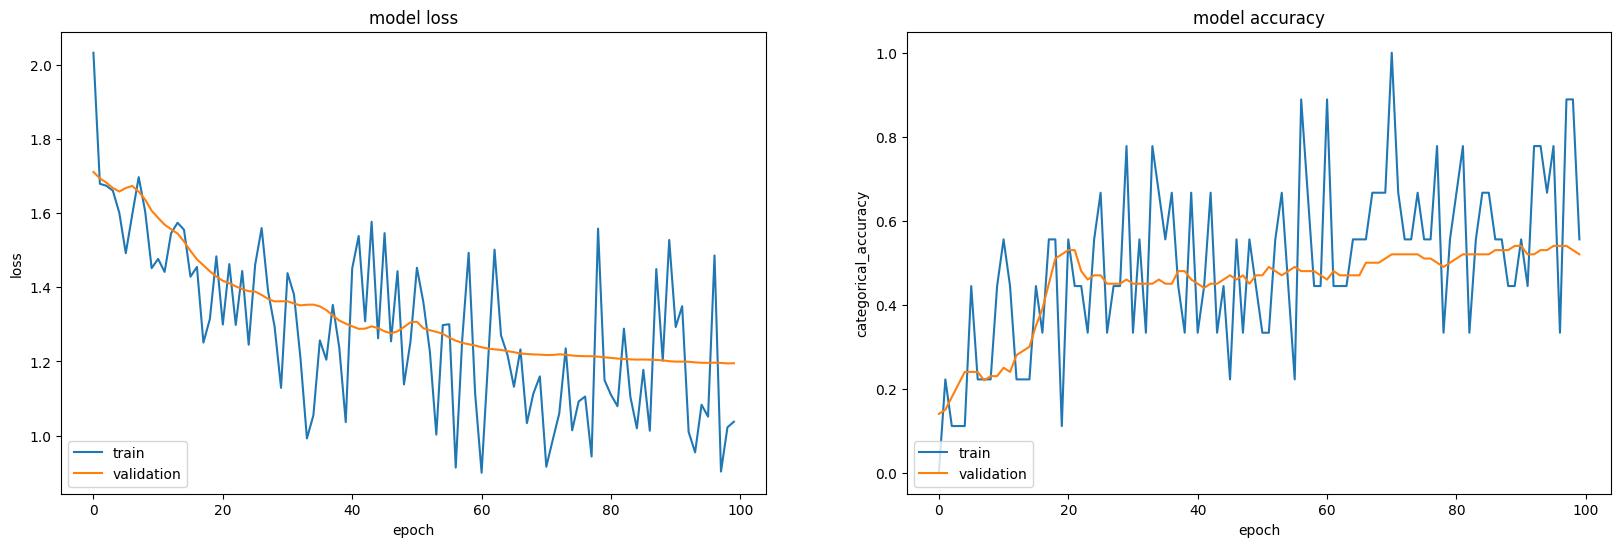

In [22]:
# # Without Augmentation
# fit_model(model_resnet_gru, 'model_resnet_gru')

Epoch 101/200

Epoch 101: val_loss improved from inf to 1.19393, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 8s - loss: 1.1112 - categorical_accuracy: 0.7778 - val_loss: 1.1939 - val_categorical_accuracy: 0.5400 - lr: 8.0000e-07 - 8s/epoch - 3s/step
Epoch 102/200

Epoch 102: val_loss improved from 1.19393 to 1.19378, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 8s - loss: 1.0320 - categorical_accuracy: 0.6667 - val_loss: 1.1938 - val_categorical_accuracy: 0.5300 - lr: 8.0000e-07 - 8s/epoch - 3s/step
Epoch 103/200

Epoch 103: val_loss improved from 1.19378 to 1.19259, saving model to /tmp/models/model_resnet_gru_2023-04-2512_03_30.461425/best_model.h5
3/3 - 8s - loss: 1.2215 - categorical_accuracy: 0.4444 - val_loss: 1.1926 - val_categorical_accuracy: 0.5300 - lr: 8.0000e-07 - 8s/epoch - 3s/step
Epoch 104/200

Epoch 104: val_loss did not improve from 1.19259
3/3 - 7s - loss: 1.3339 - categorical

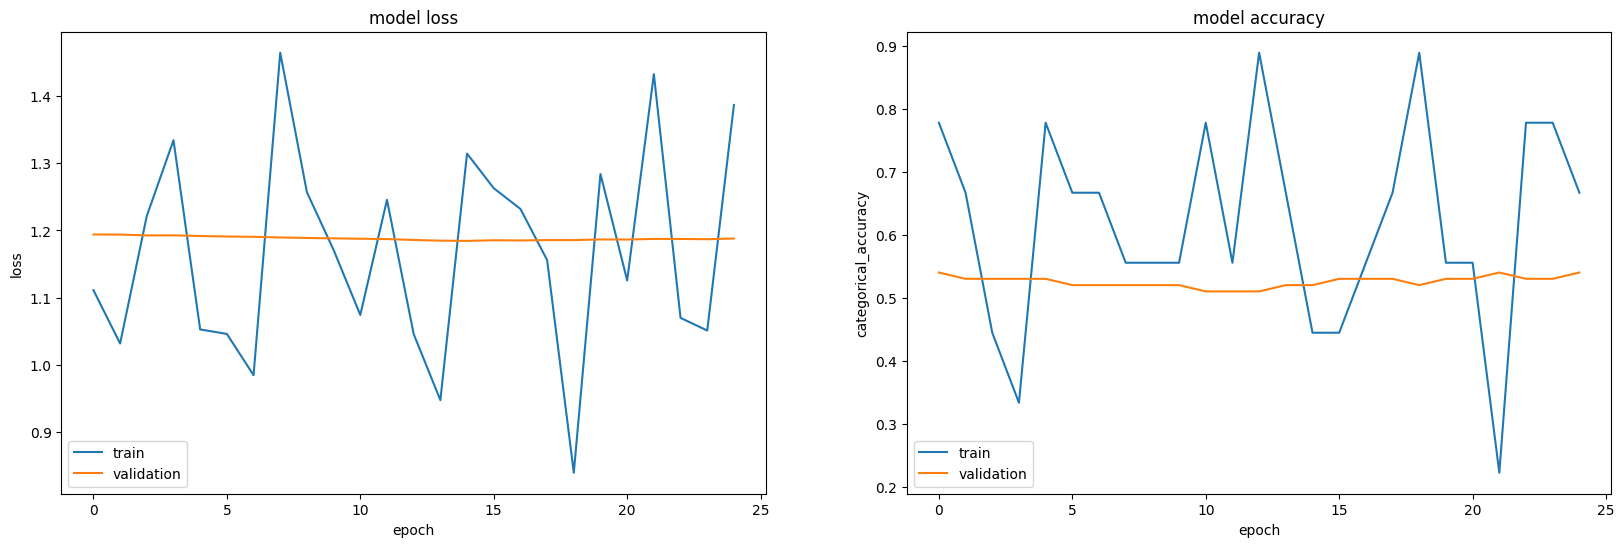

In [23]:
# # Train for more epochs
# history = model_resnet_gru.fit(x=train_generator, steps_per_epoch=steps_per_epoch, initial_epoch=100, epochs=200, verbose=2,
#                     callbacks=getCallbacks('model_resnet_gru'), validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None)
# plot_perf(history)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.75938, saving model to /tmp/models/model_resnet_gru_2023-04-2511_28_42.522897/best_model.h5
5/5 - 17s - loss: 1.4804 - categorical_accuracy: 0.3000 - val_loss: 1.7594 - val_categorical_accuracy: 0.2500 - lr: 3.2000e-08 - 17s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.75938 to 1.75784, saving model to /tmp/models/model_resnet_gru_2023-04-2511_28_42.522897/best_model.h5
5/5 - 9s - loss: 1.5668 - categorical_accuracy: 0.3000 - val_loss: 1.7578 - val_categorical_accuracy: 0.2400 - lr: 3.2000e-08 - 9s/epoch - 2s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.75784
5/5 - 8s - loss: 1.7287 - categorical_accuracy: 0.2333 - val_loss: 1.7606 - val_categorical_accuracy: 0.2500 - lr: 3.2000e-08 - 8s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.75784 to 1.75476, saving model to /tmp/models/model_resnet_gru_2023-04-2511_28_42.522897/best_model.h5
5/5 - 9s - loss: 1.9743 - categorical_accuracy: 0.1

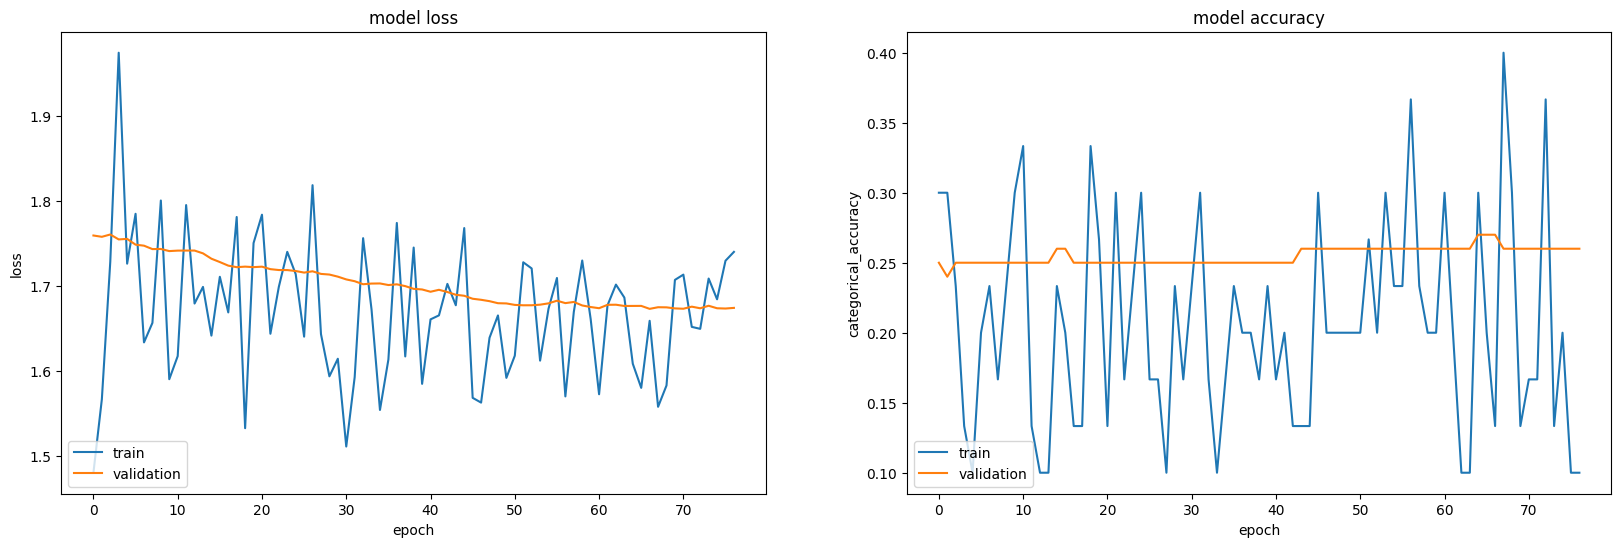

In [22]:
# # With Augmentation
# fit_model(model_resnet_gru, 'model_resnet_gru')